# Basic HEMS implementation using MILP

In [1]:
import cvxpy as cp
import numpy as np

## Constants

In [2]:
from HEMS.const import DT_DEFAULT

T = 24 * int(1 / DT_DEFAULT) - 1  # number of time steps per day
solver = cp.HIGHS
print(f"DT_DEFAULT = {DT_DEFAULT} h, T = {T} steps/day")

DT_DEFAULT = 0.25 h, T = 95 steps/day


## EV control prototyping

In [3]:
from HEMS.load import EV

In [4]:
ev = EV(T)

# Simple time-of-use electricity price signal [€/kWh]
# Cheap at night (0–7h, 21–24h), expensive during the day (7–21h)
price = np.where(
    np.arange(T) < 7 * 4,      # 00:00–07:00
    0.05,
    np.where(
        np.arange(T) >= 21 * 4,    # 21:00–24:00
        0.05,
        0.25,                        # 07:00–21:00
    ),
)

# Schedule two trips: 8:00–18:00 consuming 30 kWh, and 19:00–21:00 consuming 25 kWh
ev.schedule_trips([(8 * 4, 18 * 4, 30.0), (19 * 4, 20 * 4, 25.0)])

# Cost-minimising objective: pay as little as possible for charging
objective = cp.Minimize(ev.dt * (price @ ev.P))

prob = cp.Problem(objective, ev.constraints())

assert prob.is_dcp(), "Problem is not DCP compliant"
assert prob.is_dpp(), "Problem is not DPP compliant"

prob.solve(solver=solver, verbose=False)
print(f"Status : {prob.status}")
print(f"Cost   : {prob.value:.4f} €")


Status : optimal
Cost   : 4.7611 €


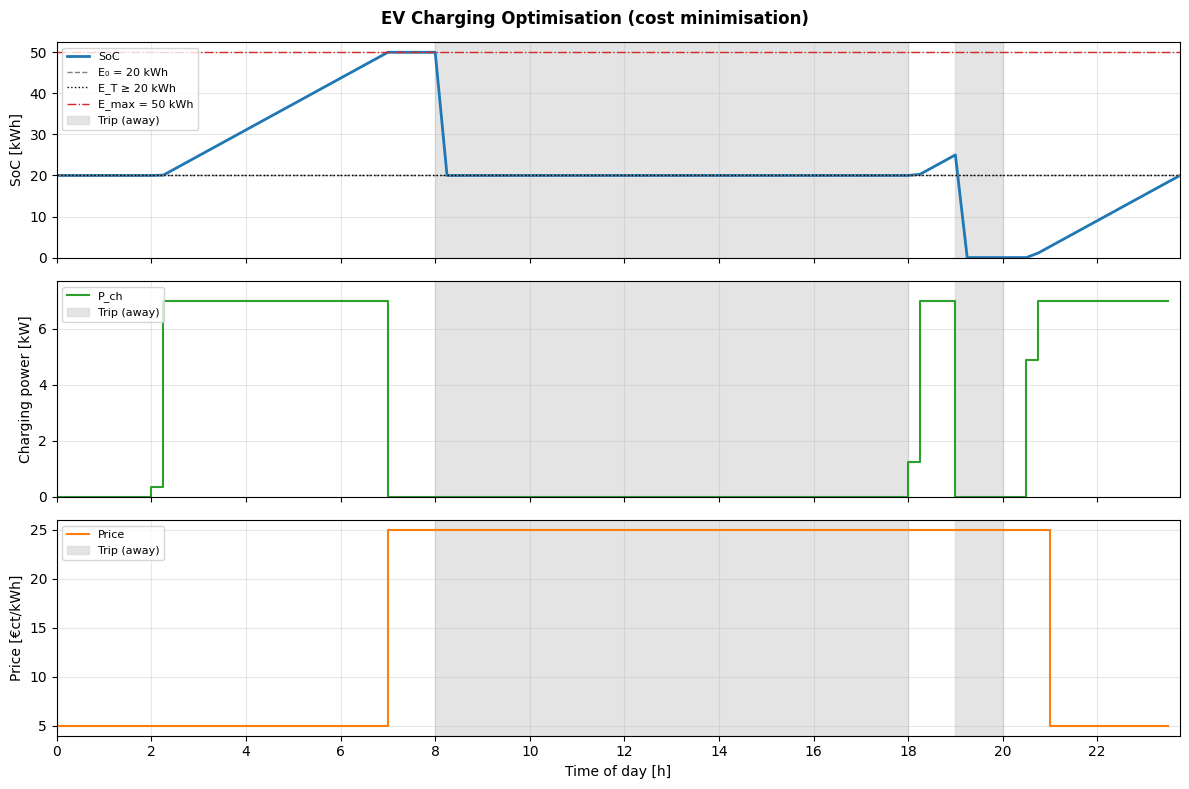

In [5]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

t_power = np.arange(T) * ev.dt          # time axis for power/price [h]
t_soc   = np.arange(T + 1) * ev.dt      # time axis for SoC [h]

# Extract solved values
soc   = ev.E.value                       # kWh,  shape (T+1,)
p_ch  = ev.P_ch.value                    # kW,   shape (T,)
avail = ev.a.value                       # 0/1,  shape (T,)


def shade_trips(ax, t_power, avail, dt, **kwargs):
    """Shade each contiguous unavailability window on ax."""
    unavail = (avail == 0).astype(int)
    edges = np.diff(np.concatenate(([0], unavail, [0])))
    starts = t_power[np.where(edges == 1)[0]]
    ends   = t_power[np.where(edges == -1)[0] - 1] + dt
    first = True
    for s, e in zip(starts, ends):
        ax.axvspan(s, e, label="Trip (away)" if first else None, **kwargs)
        first = False


fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)
fig.suptitle("EV Charging Optimisation (cost minimisation)", fontweight="bold")

trip_kwargs = dict(color="lightgrey", alpha=0.6)

# --- Panel 1: State of Charge ---
ax = axes[0]
ax.plot(t_soc, soc, color="tab:blue", lw=2, label="SoC")
ax.axhline(ev.E_0.value, color="grey",    ls="--", lw=1, label=f"E₀ = {ev.E_0.value:.0f} kWh")
ax.axhline(ev.E_T.value, color="black",   ls=":",  lw=1, label=f"E_T ≥ {ev.E_T.value:.0f} kWh")
ax.axhline(ev.E_max,     color="tab:red", ls="-.", lw=1, label=f"E_max = {ev.E_max:.0f} kWh")
shade_trips(ax, t_power, avail, ev.dt, **trip_kwargs)
ax.set_ylabel("SoC [kWh]")
ax.set_ylim(0, ev.E_max * 1.05)
ax.legend(loc="upper left", fontsize=8)
ax.grid(True, alpha=0.3)

# --- Panel 2: Charging power ---
ax = axes[1]
ax.step(t_power, p_ch, where="post", color="tab:green", lw=1.5, label="P_ch")
shade_trips(ax, t_power, avail, ev.dt, **trip_kwargs)
ax.set_ylabel("Charging power [kW]")
ax.set_ylim(0, ev.P_ch_max * 1.1)
ax.legend(loc="upper left", fontsize=8)
ax.grid(True, alpha=0.3)

# --- Panel 3: Electricity price ---
ax = axes[2]
ax.step(t_power, price * 100, where="post", color="tab:orange", lw=1.5, label="Price")
shade_trips(ax, t_power, avail, ev.dt, **trip_kwargs)
grey_patch = mpatches.Patch(**trip_kwargs, label="Trip (away)")
ax.legend(handles=[ax.get_lines()[0], grey_patch], loc="upper left", fontsize=8)
ax.set_ylabel("Price [€ct/kWh]")
ax.set_xlabel("Time of day [h]")
ax.set_xlim(0, T * ev.dt)
ax.set_xticks(range(0, int(T * ev.dt) + 1, 2))
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## Solar generation prototyping

In [6]:
from HEMS.solar import Solar
from HEMS.weather import fetch_open_meteo, resample_weather
import pandas as pd

# --- Fetch historical weather data for Amsterdam, June 2025 ---
weather = fetch_open_meteo(
    latitude=52.37,
    longitude=4.90,
    start_date="2025-06-01",
    end_date="2025-06-30",
    timezone="Europe/Amsterdam",
)
print(f"Fetched {len(weather)} hourly records")

# --- Resample to DT_DEFAULT (15-min) ---
weather = resample_weather(weather, dt=DT_DEFAULT)
print(f"Resampled to {len(weather)} records at {DT_DEFAULT*60:.0f}-min resolution")
print(weather.head())

Fetched 720 hourly records
Resampled to 2877 records at 15-min resolution
                           ghi  dni  dhi  temp_air  wind_speed
time                                                          
2025-06-01 00:00:00+02:00  0.0  0.0  0.0     17.30    2.472222
2025-06-01 00:15:00+02:00  0.0  0.0  0.0     17.15    2.263889
2025-06-01 00:30:00+02:00  0.0  0.0  0.0     17.00    2.055556
2025-06-01 00:45:00+02:00  0.0  0.0  0.0     16.85    1.847222
2025-06-01 01:00:00+02:00  0.0  0.0  0.0     16.70    1.638889


In [7]:
# --- Create a 5 kWp south-facing PV system in Amsterdam ---
T_sol = len(weather)

solar = Solar(
    T=T_sol,
    dt=DT_DEFAULT,
    pdc0=5.0,           # 5 kWp array
    pac0=5.0,           # 5 kW inverter
    surface_tilt=35.0,  # 35° tilt
    surface_azimuth=180.0,  # south-facing
    latitude=52.37,
    longitude=4.90,
    timezone="Europe/Amsterdam",
    curtailable=False,
)

# Compute AC generation from the fetched weather data
pac_kw = solar.compute_generation(
    times=weather.index,
    ghi=weather["ghi"].to_numpy(),
    temp_air=weather["temp_air"].to_numpy(),
    wind_speed=weather["wind_speed"].to_numpy(),
    dni=weather["dni"].to_numpy(),
    dhi=weather["dhi"].to_numpy(),
)

monthly_yield = np.sum(pac_kw) * DT_DEFAULT
peak_power = pac_kw.max()
print(f"Time steps    : {T_sol} ({DT_DEFAULT*60:.0f}-min resolution)")
print(f"Peak AC power : {peak_power:.2f} kW")
print(f"Monthly yield : {monthly_yield:.1f} kWh")
print(f"Capacity factor: {monthly_yield / (solar.pdc0 * T_sol * DT_DEFAULT) * 100:.1f}%")

Time steps    : 2877 (15-min resolution)
Peak AC power : 4.31 kW
Monthly yield : 873.5 kWh
Capacity factor: 24.3%


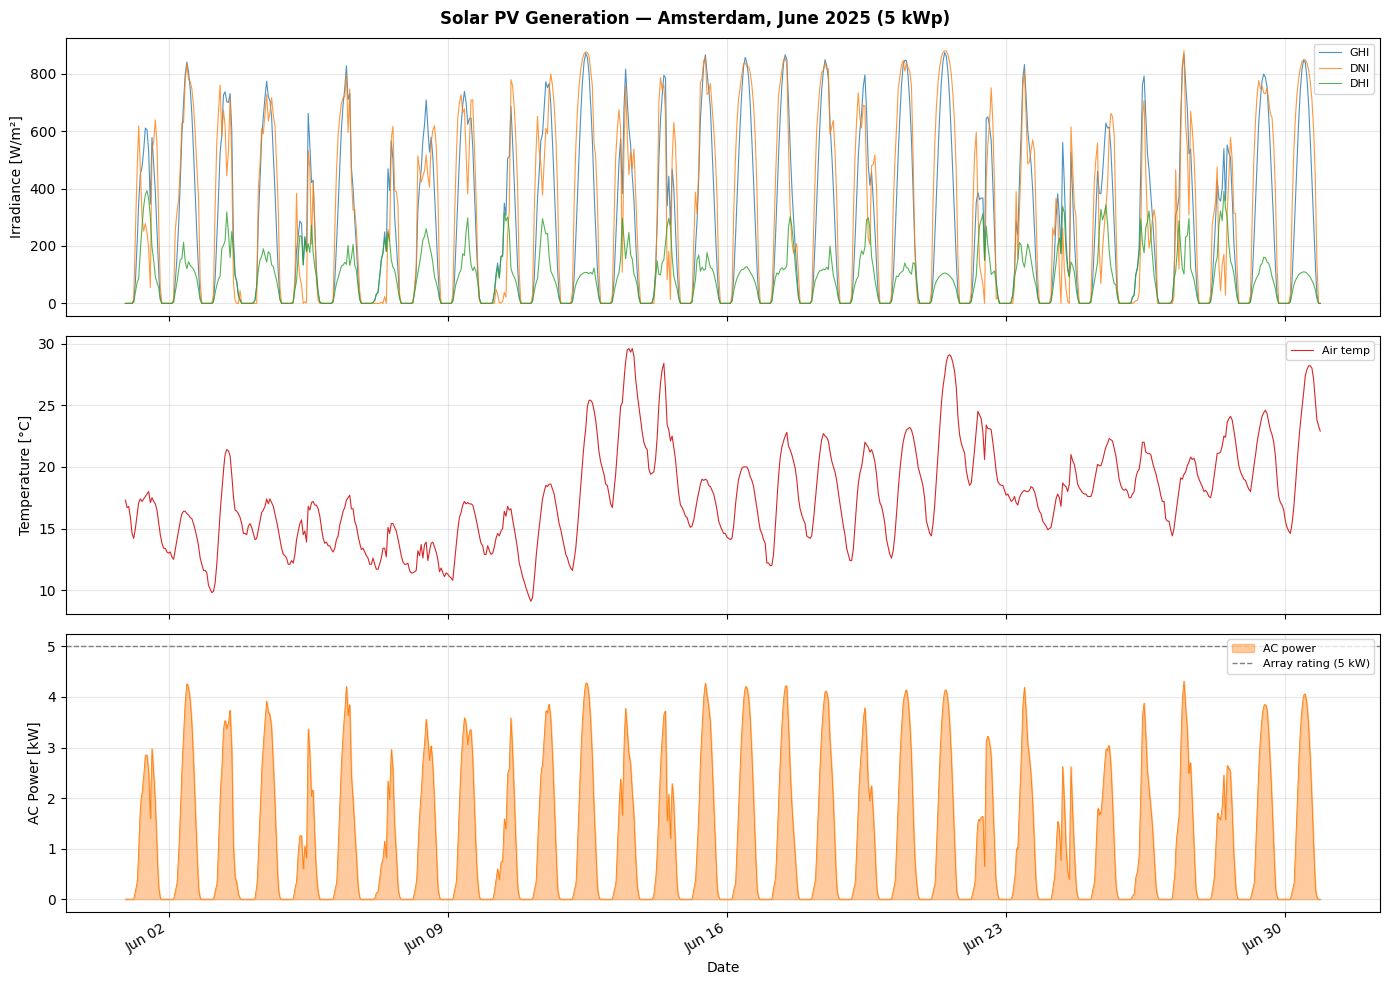

In [8]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)
fig.suptitle("Solar PV Generation — Amsterdam, June 2025 (5 kWp)", fontweight="bold")

times = weather.index

# --- Panel 1: Irradiance ---
ax = axes[0]
ax.plot(times, weather["ghi"], lw=0.8, alpha=0.8, label="GHI")
ax.plot(times, weather["dni"], lw=0.8, alpha=0.8, label="DNI")
ax.plot(times, weather["dhi"], lw=0.8, alpha=0.8, label="DHI")
ax.set_ylabel("Irradiance [W/m²]")
ax.legend(loc="upper right", fontsize=8)
ax.grid(True, alpha=0.3)

# --- Panel 2: Temperature ---
ax = axes[1]
ax.plot(times, weather["temp_air"], lw=0.8, color="tab:red", label="Air temp")
ax.set_ylabel("Temperature [°C]")
ax.legend(loc="upper right", fontsize=8)
ax.grid(True, alpha=0.3)

# --- Panel 3: AC power output ---
ax = axes[2]
ax.fill_between(times, pac_kw, alpha=0.4, color="tab:orange", label="AC power")
ax.plot(times, pac_kw, lw=0.6, color="tab:orange")
ax.axhline(solar.pdc0, color="grey", ls="--", lw=1, label=f"Array rating ({solar.pdc0:.0f} kW)")
ax.set_ylabel("AC Power [kW]")
ax.set_xlabel("Date")
ax.legend(loc="upper right", fontsize=8)
ax.grid(True, alpha=0.3)

ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MO))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %d"))
fig.autofmt_xdate(rotation=30)

plt.tight_layout()
plt.show()

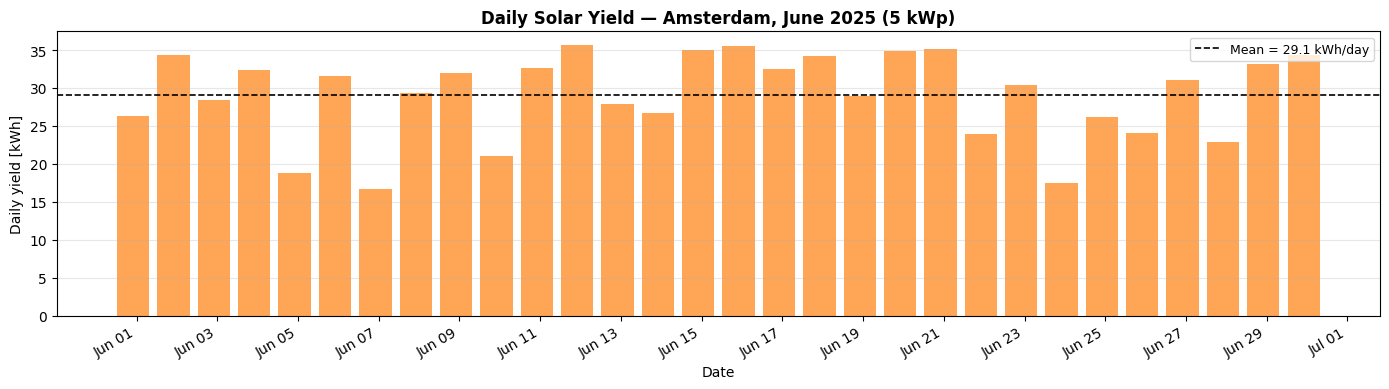

In [9]:
# --- Daily yield bar chart ---
daily_yield = pd.Series(pac_kw * DT_DEFAULT, index=weather.index).resample("D").sum()

fig, ax = plt.subplots(figsize=(14, 4))
ax.bar(daily_yield.index, daily_yield.values, width=0.8, color="tab:orange", alpha=0.7)
ax.axhline(daily_yield.mean(), color="black", ls="--", lw=1.2,
           label=f"Mean = {daily_yield.mean():.1f} kWh/day")
ax.set_ylabel("Daily yield [kWh]")
ax.set_xlabel("Date")
ax.set_title("Daily Solar Yield — Amsterdam, June 2025 (5 kWp)", fontweight="bold")
ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %d"))
fig.autofmt_xdate(rotation=30)
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3, axis="y")
plt.tight_layout()
plt.show()

### Curtailment demo (single day)

We create a **curtailable** solar model for the sunniest day in June and impose a
feed-in limit. The optimiser decides how much generation to keep versus curtail.

In [10]:
# --- Pick the sunniest day from the month ---
best_day = daily_yield.idxmax().strftime("%Y-%m-%d")
day_mask = weather.index.normalize() == pd.Timestamp(best_day, tz="Europe/Amsterdam")
weather_day = weather.loc[day_mask]
T_day = len(weather_day)

print(f"Sunniest day: {best_day}  ({daily_yield.max():.1f} kWh)")
print(f"Time steps:   {T_day}  (dt={DT_DEFAULT} h)")

# --- Curtailable solar model for that day ---
solar_curt = Solar(
    T=T_day,
    dt=DT_DEFAULT,
    pdc0=5.0,
    pac0=5.0,
    surface_tilt=35.0,
    surface_azimuth=180.0,
    latitude=52.37,
    longitude=4.90,
    timezone="Europe/Amsterdam",
    curtailable=True,  # <-- optimiser can curtail
)

# Compute the maximum available generation
pac_day = solar_curt.compute_generation(
    times=weather_day.index,
    ghi=weather_day["ghi"].values,
    temp_air=weather_day["temp_air"].values,
    wind_speed=weather_day["wind_speed"].values,
    dni=weather_day["dni"].values,
    dhi=weather_day["dhi"].values,
)

# --- Feed-in limit: curtail anything above 3 kW ---
feed_in_limit = 3.0  # kW

constraints = solar_curt.constraints()
constraints += [solar_curt.P <= feed_in_limit]

# Maximise total generation subject to the feed-in cap
objective = cp.Maximize(cp.sum(solar_curt.P))
prob = cp.Problem(objective, constraints)
prob.solve(solver=solver)

p_curt = solar_curt.P.value
energy_available = np.sum(pac_day) * DT_DEFAULT
energy_delivered = np.sum(p_curt) * DT_DEFAULT
energy_curtailed = energy_available - energy_delivered

print(f"\nStatus        : {prob.status}")
print(f"Available     : {energy_available:.2f} kWh")
print(f"Delivered     : {energy_delivered:.2f} kWh")
print(f"Curtailed     : {energy_curtailed:.2f} kWh ({energy_curtailed/energy_available*100:.1f}%)")

Sunniest day: 2025-06-12  (35.7 kWh)
Time steps:   96  (dt=0.25 h)

Status        : optimal
Available     : 35.68 kWh
Delivered     : 30.21 kWh
Curtailed     : 5.47 kWh (15.3%)


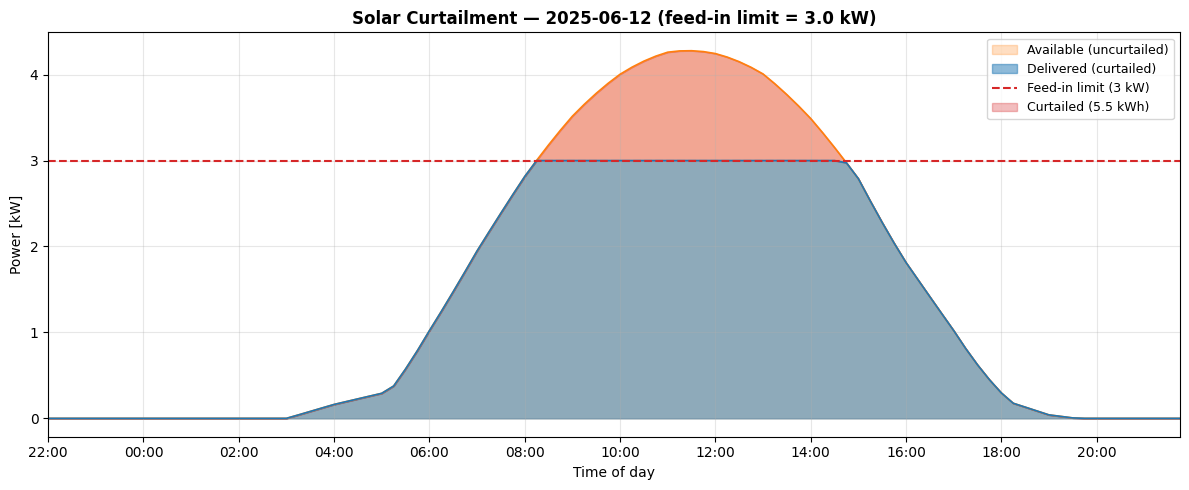

In [11]:
# --- Curtailment visualisation ---
hours = np.arange(T_day) * DT_DEFAULT
t_day = weather_day.index

fig, ax = plt.subplots(figsize=(12, 5))

# Available generation (uncurtailed)
ax.fill_between(t_day, pac_day, alpha=0.25, color="tab:orange", label="Available (uncurtailed)")
ax.plot(t_day, pac_day, lw=1.2, color="tab:orange")

# Delivered (after curtailment)
ax.fill_between(t_day, p_curt, alpha=0.5, color="tab:blue", label="Delivered (curtailed)")
ax.plot(t_day, p_curt, lw=1.2, color="tab:blue")

# Feed-in limit
ax.axhline(feed_in_limit, color="tab:red", ls="--", lw=1.5,
           label=f"Feed-in limit ({feed_in_limit:.0f} kW)")

# Shade curtailed energy
ax.fill_between(t_day, p_curt, pac_day, alpha=0.3, color="tab:red",
                label=f"Curtailed ({energy_curtailed:.1f} kWh)")

ax.set_ylabel("Power [kW]")
ax.set_xlabel("Time of day")
ax.set_title(f"Solar Curtailment — {best_day} (feed-in limit = {feed_in_limit} kW)", fontweight="bold")
ax.xaxis.set_major_locator(mdates.HourLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
ax.set_xlim(t_day[0], t_day[-1])
ax.legend(loc="upper right", fontsize=9)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Heat pump prototyping (1R1C model)

Non-controllable fixed load using a 1R1C building envelope and a
Carnot-based COP model.  Parameters represent a typical Dutch row house
(`H = 0.20 kW/°C`, `C = 8 kWh/°C`, `T_set = 20 °C`, `T_supply = 35 °C`).

We fetch **winter** weather (January 2025, Amsterdam) so the heat pump
faces realistic cold-weather conditions.

In [12]:
from HEMS.heat_pump import HeatPump

# --- Fetch cold winter weather (January 2025, Amsterdam) ---
weather_winter = fetch_open_meteo(
    latitude=52.37,
    longitude=4.90,
    start_date="2025-01-01",
    end_date="2025-01-31",
    timezone="Europe/Amsterdam",
)
weather_winter = resample_weather(weather_winter, dt=DT_DEFAULT)
print(f"Winter weather: {len(weather_winter)} records at {DT_DEFAULT*60:.0f}-min")
print(f"Temp range: {weather_winter['temp_air'].min():.1f} – {weather_winter['temp_air'].max():.1f} °C")

# Use 7 coldest consecutive days
daily_mean_temp = weather_winter["temp_air"].resample("D").mean()
# rolling 7-day mean → find the window with lowest average
rolling_temp = daily_mean_temp.rolling(7).mean()
cold_week_end = rolling_temp.idxmin()
cold_week_start = cold_week_end - pd.Timedelta(days=6)
print(f"Coldest week: {cold_week_start.strftime('%Y-%m-%d')} to {cold_week_end.strftime('%Y-%m-%d')} "
      f"(mean {rolling_temp.min():.1f} °C)")

mask = (weather_winter.index >= cold_week_start) & (
    weather_winter.index < cold_week_end + pd.Timedelta(days=1)
)
weather_hp = weather_winter.loc[mask]
T_hp = len(weather_hp)
hp_days = 7

# Shared building + HP parameters (only T_supply differs)
hp_kwargs = dict(
    T_amb=weather_hp["temp_air"].to_numpy(),
    dt=DT_DEFAULT,
    H=0.20, C=8.0, T_set=20.0, T_in_0=20.0,
    eta_carnot=0.45, P_hp_max=8.0, Q_int=0.7,
)

# --- Scenario A: Low-temperature (underfloor heating) ---
hp_lo = HeatPump(**hp_kwargs, T_supply=35.0)
P_el_lo = hp_lo.P.value

# --- Scenario B: High-temperature (radiator system) ---
hp_hi = HeatPump(**hp_kwargs, T_supply=55.0)
P_el_hi = hp_hi.P.value

print(f"\n{'':30s} {'T_supply=35°C':>14s}  {'T_supply=55°C':>14s}")
print(f"{'Peak elec power [kW]':30s} {P_el_lo.max():14.2f}  {P_el_hi.max():14.2f}")
print(f"{'Total elec [kWh]':30s} {np.sum(P_el_lo)*DT_DEFAULT:14.1f}  {np.sum(P_el_hi)*DT_DEFAULT:14.1f}")
print(f"{'COP range':30s} {hp_lo.cop.min():.2f}–{hp_lo.cop.max():.2f}       {hp_hi.cop.min():.2f}–{hp_hi.cop.max():.2f}")
print(f"{'Q_hp peak [kW]':30s} {hp_lo.Q_hp.max():14.2f}  {hp_hi.Q_hp.max():14.2f}")

Winter weather: 2973 records at 15-min
Temp range: -2.3 – 12.3 °C
Coldest week: 2025-01-16 to 2025-01-22 (mean 1.0 °C)

                                T_supply=35°C   T_supply=55°C
Peak elec power [kW]                     1.01            1.46
Total elec [kWh]                        128.9           191.7
COP range                      3.72–4.99       2.58–3.09
Q_hp peak [kW]                           3.76            3.76


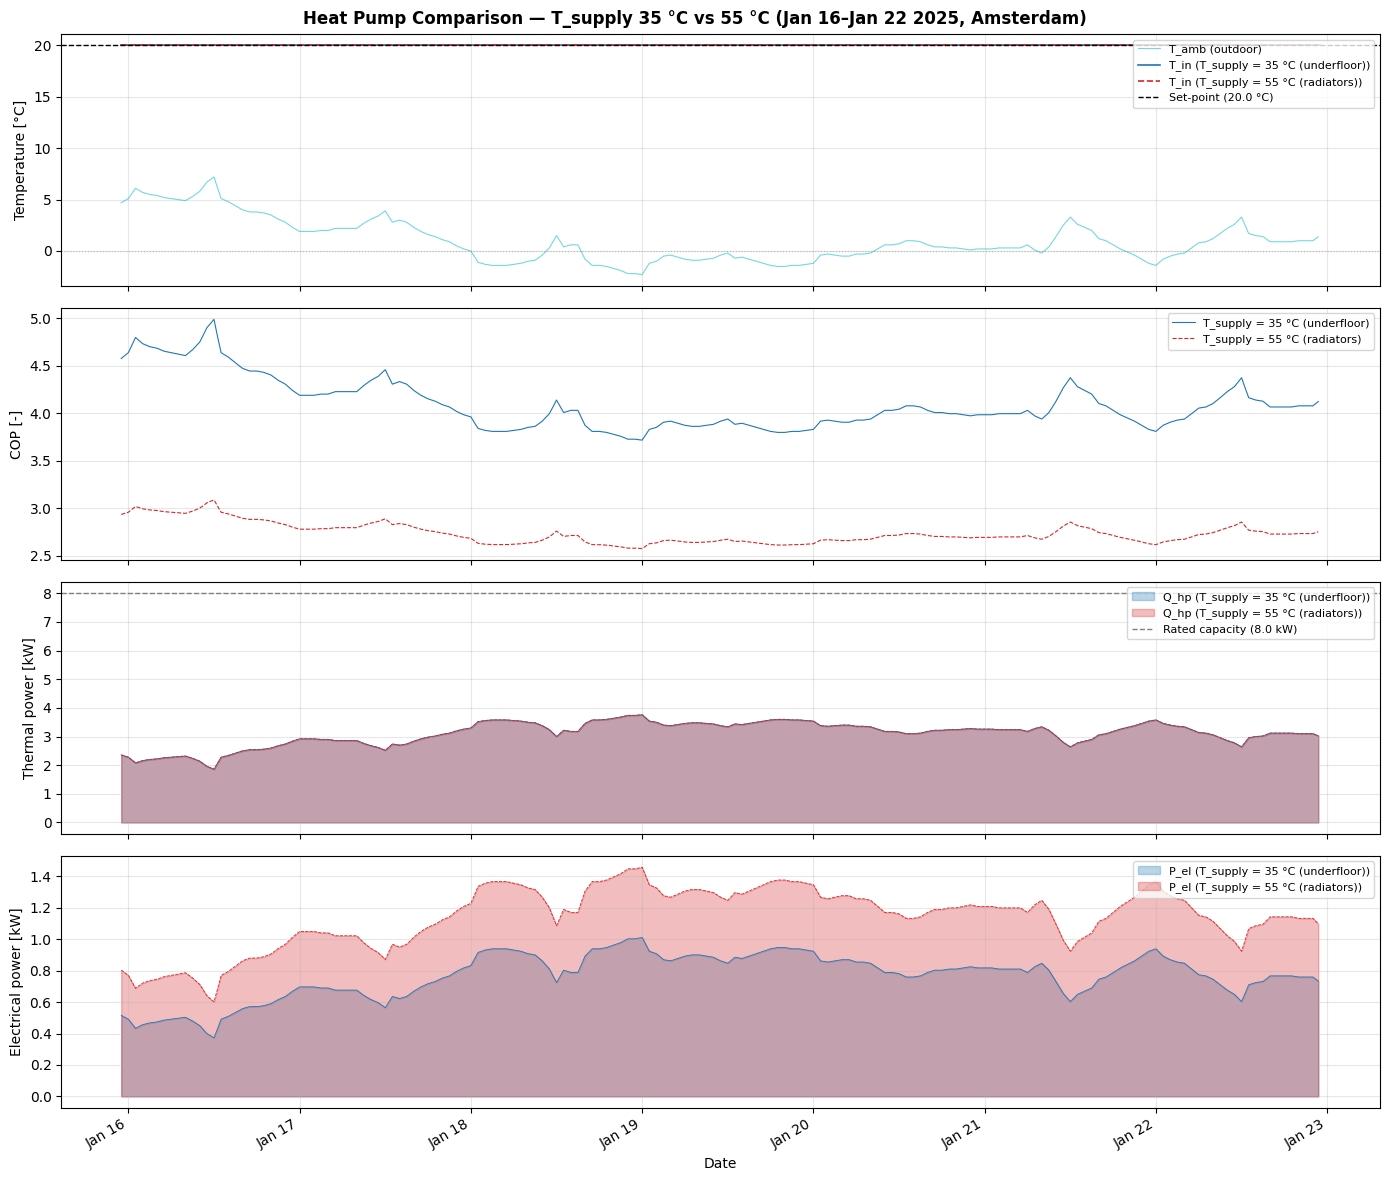

In [13]:
# --- Heat pump comparison: T_supply = 35 °C vs 55 °C (4-panel) ---
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

t_hp = weather_hp.index
t_hp_in = weather_hp.index.append(
    pd.DatetimeIndex([weather_hp.index[-1] + pd.Timedelta(hours=DT_DEFAULT)])
)

fig, axes = plt.subplots(4, 1, figsize=(14, 12), sharex=True)
fig.suptitle(
    f"Heat Pump Comparison — T_supply 35 °C vs 55 °C "
    f"({cold_week_start.strftime('%b %d')}–{cold_week_end.strftime('%b %d %Y')}, Amsterdam)",
    fontweight="bold",
)

c_lo, c_hi = "tab:blue", "tab:red"
label_lo, label_hi = "T_supply = 35 °C (underfloor)", "T_supply = 55 °C (radiators)"

# --- Panel 1: Temperatures ---
ax = axes[0]
ax.plot(t_hp, hp_lo.T_amb[:T_hp], lw=0.8, color="tab:cyan", alpha=0.6, label="T_amb (outdoor)")
ax.plot(t_hp_in, hp_lo.T_in, lw=1.2, color=c_lo, label=f"T_in ({label_lo})")
ax.plot(t_hp_in, hp_hi.T_in, lw=1.2, color=c_hi, ls="--", label=f"T_in ({label_hi})")
ax.axhline(hp_lo.T_set, color="black", ls="--", lw=1, label=f"Set-point ({hp_lo.T_set} °C)")
ax.axhline(0, color="grey", ls=":", lw=0.8, alpha=0.5)
ax.set_ylabel("Temperature [°C]")
ax.legend(loc="upper right", fontsize=8)
ax.grid(True, alpha=0.3)

# --- Panel 2: COP ---
ax = axes[1]
ax.plot(t_hp, hp_lo.cop, lw=0.8, color=c_lo, label=label_lo)
ax.plot(t_hp, hp_hi.cop, lw=0.8, color=c_hi, ls="--", label=label_hi)
ax.set_ylabel("COP [-]")
ax.legend(loc="upper right", fontsize=8)
ax.grid(True, alpha=0.3)

# --- Panel 3: Thermal power (identical — same building) ---
ax = axes[2]
ax.fill_between(t_hp, hp_lo.Q_hp, alpha=0.3, color=c_lo, label=f"Q_hp ({label_lo})")
ax.plot(t_hp, hp_lo.Q_hp, lw=0.6, color=c_lo)
ax.fill_between(t_hp, hp_hi.Q_hp, alpha=0.3, color=c_hi, label=f"Q_hp ({label_hi})")
ax.plot(t_hp, hp_hi.Q_hp, lw=0.6, color=c_hi, ls="--")
ax.axhline(hp_lo.P_hp_max, color="grey", ls="--", lw=1, label=f"Rated capacity ({hp_lo.P_hp_max} kW)")
ax.set_ylabel("Thermal power [kW]")
ax.legend(loc="upper right", fontsize=8)
ax.grid(True, alpha=0.3)

# --- Panel 4: Electrical power ---
ax = axes[3]
ax.fill_between(t_hp, P_el_lo, alpha=0.3, color=c_lo, label=f"P_el ({label_lo})")
ax.plot(t_hp, P_el_lo, lw=0.6, color=c_lo)
ax.fill_between(t_hp, P_el_hi, alpha=0.3, color=c_hi, label=f"P_el ({label_hi})")
ax.plot(t_hp, P_el_hi, lw=0.6, color=c_hi, ls="--")
ax.set_ylabel("Electrical power [kW]")
ax.set_xlabel("Date")
ax.legend(loc="upper right", fontsize=8)
ax.grid(True, alpha=0.3)

ax.xaxis.set_major_locator(mdates.DayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %d"))
fig.autofmt_xdate(rotation=30)

plt.tight_layout()
plt.show()

## HEMS Rolling-Horizon Simulation — March 2025

We run a **cost-optimal** day-ahead schedule for 31 days, re-solving the HEMS problem every 24 hours with updated forecasts:

| Component | Specification |
|---|---|
| **PV** | 5 kWp, south-facing (35° tilt), curtailable |
| **Battery** | 10 kWh / 5 kW, 95% round-trip efficiency |
| **Heat pump** | Air-source, T_supply = 35 °C (underfloor), 1R1C model |
| **EV** | 50 kWh battery, 7 kW charger, 10 kWh/day commute (weekdays) |
| **Base load** | 0.5 kW constant |
| **Price** | Real NL day-ahead spot prices (Jeroen Punt, 2025) — 15-min resolution |
| **Feed-in** | 70% of spot price (approximation of Dutch saldering phase-out) |

In [14]:
# Fetch March 2025 weather for Amsterdam (+ 1 extra day for boundary)
weather_mar = fetch_open_meteo(
    latitude=52.37, longitude=4.90,
    start_date="2025-03-01", end_date="2025-04-01",
    timezone="Europe/Amsterdam",
)
weather_mar = resample_weather(weather_mar, dt=DT_DEFAULT)
print(f"Weather: {len(weather_mar)} records at {DT_DEFAULT*60:.0f}-min resolution")
print(f"Range: {weather_mar.index[0]} to {weather_mar.index[-1]}")

Weather: 3065 records at 15-min resolution
Range: 2025-03-01 00:00:00+01:00 to 2025-04-01 23:00:00+02:00


In [15]:
from HEMS.hems import HEMS, Objective
from HEMS.battery import Battery
from HEMS.base import BaseLoad
from HEMS.heat_pump import HeatPump
from pathlib import Path

# --- Load real NL day-ahead spot prices (15-min, EUR/kWh excl. tax) ---
price_csv = Path(__file__).resolve().parent / "../../day-ahead-prices-nl/data/" \
            "jeroen_punt_nl_dynamische_stroomprijzen_jaar_2025.csv" \
            if "__file__" in dir() else \
            Path("/home/langestefan/dev/projects/2026/langestefan.github.io/"
                 "_posts/energy/day-ahead-prices-nl/data/"
                 "jeroen_punt_nl_dynamische_stroomprijzen_jaar_2025.csv")
prices_nl = pd.read_csv(
    price_csv, sep=";", decimal=",",
    parse_dates=["datum_nl"], index_col="datum_nl",
)
prices_nl.index = prices_nl.index.tz_localize("Europe/Amsterdam", ambiguous="NaT", nonexistent="NaT")
prices_nl = prices_nl[prices_nl.index.notna()]
prices_nl = prices_nl.rename(columns={"prijs_excl_belastingen": "price_eur_kwh"})

# Extract March 2025 prices
prices_mar = prices_nl.loc["2025-03-01":"2025-03-31", "price_eur_kwh"]
print(f"Loaded {len(prices_mar)} price records for March 2025")
print(f"  Range : {prices_mar.index[0]} → {prices_mar.index[-1]}")
print(f"  Mean  : {prices_mar.mean():.4f} EUR/kWh")
print(f"  Min   : {prices_mar.min():.4f} EUR/kWh")
print(f"  Max   : {prices_mar.max():.4f} EUR/kWh")

# --- NL electricity cost structure (Tibber, 2025) ---
# import_price[t] = (spot[t] + PROCUREMENT_FEE + ENERGY_TAX) × (1 + VAT)
# export_price[t] = spot[t] + SELL_BACK_CREDIT
#
# Available supplier presets: HEMS.SUPPLIERS  (Tibber, Zonneplan, Frank Energie)
SUPPLIER         = "Tibber"
PROCUREMENT_FEE  = HEMS.SUPPLIERS[SUPPLIER]["procurement_fee"]   # 0.0248 €/kWh
SELL_BACK_CREDIT = HEMS.SUPPLIERS[SUPPLIER]["sell_back_credit"]  # 0.0000 €/kWh
MONTHLY_FIXED    = HEMS.SUPPLIERS[SUPPLIER]["monthly_fixed_cost"] # 5.99 €/mo
ENERGY_TAX       = 0.09160   # €/kWh  NL energiebelasting 2025 (excl. VAT)
VAT              = 0.21      # 21% BTW

print(f"\nSupplier: {SUPPLIER}")
print(f"  Procurement fee : {PROCUREMENT_FEE:.4f} €/kWh")
print(f"  Sell-back credit: {SELL_BACK_CREDIT:.4f} €/kWh")
print(f"  Energy tax      : {ENERGY_TAX:.5f} €/kWh")
print(f"  VAT             : {VAT*100:.0f}%")
print(f"  Monthly fixed   : {MONTHLY_FIXED:.2f} €/mo")

# Effective per-kWh cost at average spot price
avg_spot = prices_mar.mean()
eff_import = (avg_spot + PROCUREMENT_FEE + ENERGY_TAX) * (1 + VAT)
eff_export = avg_spot + SELL_BACK_CREDIT
print(f"\n  Effective import @ avg spot ({avg_spot:.4f}): {eff_import:.4f} €/kWh")
print(f"  Effective export @ avg spot ({avg_spot:.4f}): {eff_export:.4f} €/kWh")

# --- Components (24-hour horizon, T=95) ---
base_load = BaseLoad(name="base_load", P_base=0.5)

pv = Solar(
    T=T, dt=DT_DEFAULT, pdc0=5.0, curtailable=True,
    latitude=52.37, longitude=4.90,
    surface_tilt=35.0, surface_azimuth=180.0,
    timezone="Europe/Amsterdam",
)

battery = Battery(T=T, dt=DT_DEFAULT, E_max=10.0, P_ch_max=5.0, P_dis_max=5.0)
ev = EV(T=T, dt=DT_DEFAULT, name="EV")

# Initialise HP with first day's weather
w0 = weather_mar.loc["2025-03-01"].iloc[:T]
hp = HeatPump(T_amb=w0["temp_air"].values, dt=DT_DEFAULT, name="HP", T_supply=35.0)

# Use first day's price to initialise the HEMS problem
p0 = np.maximum(prices_mar.loc["2025-03-01"].values[:T], 0.0)

# --- Build HEMS (compiled once, re-solved daily) ---
hems = HEMS(
    loads=[base_load, hp], pvs=[pv], evs=[ev], battery=battery,
    price=p0,
    procurement_fee=PROCUREMENT_FEE,
    sell_back_credit=SELL_BACK_CREDIT,
    energy_tax=ENERGY_TAX,
    vat=VAT,
    monthly_fixed_cost=MONTHLY_FIXED,
    objective="cost",
)

print(f"\nHEMS compiled — DCP: {hems.problem.is_dcp()}, DPP: {hems.problem.is_dpp()}")
print(f"Loads: {[l.name for l in hems.loads]}")
print(f"PV: {[p.name for p in hems.pvs]}, Battery: {battery.name}, EV: {ev.name}")

Loaded 2972 price records for March 2025
  Range : 2025-03-01 00:00:00+01:00 → 2025-03-31 23:45:00+02:00
  Mean  : 0.0917 EUR/kWh
  Min   : -0.0330 EUR/kWh
  Max   : 0.2469 EUR/kWh

Supplier: Tibber
  Procurement fee : 0.0248 €/kWh
  Sell-back credit: 0.0000 €/kWh
  Energy tax      : 0.09160 €/kWh
  VAT             : 21%
  Monthly fixed   : 5.99 €/mo

  Effective import @ avg spot (0.0917): 0.2518 €/kWh
  Effective export @ avg spot (0.0917): 0.0917 €/kWh

HEMS compiled — DCP: True, DPP: True
Loads: ['base_load', 'HP']
PV: ['Solar'], Battery: Battery, EV: EV


In [16]:
import time

N_DAYS = 31
dates_march = pd.date_range("2025-03-01", periods=N_DAYS, freq="D")

# Daily aggregates
daily = pd.DataFrame(0.0, index=dates_march, columns=[
    "import_kWh", "export_kWh", "pv_kWh", "sc_kWh",
    "hp_kWh", "ev_kWh", "base_kWh",
    "cost_import", "cost_export", "cost_net",
    "avg_price",
])

# 15-min timeseries storage
ts_chunks = {k: [] for k in ["P_import", "P_export", "P_pv", "P_bat",
                               "P_hp", "P_ev", "P_base", "E_bat",
                               "spot", "price_import", "price_export"]}
ts_idx = []

# Initial conditions
battery.E_0.value = battery.E_max / 2
ev.E_0.value = 20.0

skipped = []
t_start = time.perf_counter()

for d in range(N_DAYS):
    ds = dates_march[d].strftime("%Y-%m-%d")

    # Positional slice: T consecutive 15-min steps from midnight.
    # This handles DST spring-forward days (23 h) by naturally
    # extending a few steps into the next calendar day.
    midnight = pd.Timestamp(ds, tz="Europe/Amsterdam")

    w_start = weather_mar.index.searchsorted(midnight)
    w = weather_mar.iloc[w_start:w_start + T]
    if len(w) < T:
        skipped.append(ds)
        continue

    p_start = prices_mar.index.searchsorted(midnight)
    day_prices = prices_mar.iloc[p_start:p_start + T].values
    if len(day_prices) < T:
        skipped.append(ds)
        continue

    # Clamp negative prices to zero for the spot-price parameter
    price_day = np.maximum(day_prices, 0.0)

    # Update HEMS spot-price parameter (cost model adds procurement/tax/VAT)
    hems.price.value = price_day

    # Update solar forecast
    pv.compute_generation(
        times=w.index, ghi=w["ghi"].values, temp_air=w["temp_air"].values,
        wind_speed=w["wind_speed"].values, dni=w["dni"].values, dhi=w["dhi"].values,
    )

    # Update heat pump (re-simulate 1R1C with today's weather)
    _hp = HeatPump(T_amb=w["temp_air"].values, dt=DT_DEFAULT, T_supply=35.0)
    hp.P.value = _hp.P.value

    # Update EV (weekdays: commute 08:00-18:00, 10 kWh; weekends: home)
    if dates_march[d].weekday() < 5:
        ev.schedule_trips([(8 * 4, 18 * 4, 10.0)])
    else:
        ev.schedule_trips([])
    ev.E_T.value = ev.E_0.value        # daily cycling
    battery.E_T.value = battery.E_0.value  # daily cycling

    # Solve
    res = hems.solve()

    # Record daily aggregates
    imp, exp = res["P_import"], res["P_export"]
    pv_gen = hems.total_pv_generation
    daily.loc[dates_march[d]] = [
        np.sum(imp) * DT_DEFAULT, np.sum(exp) * DT_DEFAULT,
        np.sum(pv_gen) * DT_DEFAULT, (np.sum(pv_gen) - np.sum(exp)) * DT_DEFAULT,
        np.sum(hp.P.value) * DT_DEFAULT,
        np.sum(np.maximum(ev.P.value, 0)) * DT_DEFAULT,
        np.sum(base_load.P.value) * DT_DEFAULT,
        res["cost_import"], res["cost_export"], res["cost"],
        np.mean(day_prices),
    ]
    # Compute effective consumer prices for this day
    vf = 1.0 + VAT
    price_import_day = (price_day + PROCUREMENT_FEE + ENERGY_TAX) * vf
    price_export_day = price_day + SELL_BACK_CREDIT

    # Record 15-min timeseries
    ts_idx.extend(w.index.tolist())
    for k, v in [("P_import", imp), ("P_export", exp), ("P_pv", pv_gen),
                  ("P_bat", battery.P.value), ("P_hp", hp.P.value),
                  ("P_ev", ev.P.value), ("P_base", base_load.P.value),
                  ("E_bat", battery.E.value[:-1]),
                  ("spot", day_prices),
                  ("price_import", price_import_day),
                  ("price_export", price_export_day)]:
        ts_chunks[k].append(v.copy())

    # Advance SoC for next day
    battery.E_0.value = float(battery.E.value[-1])
    ev.E_0.value = float(ev.E.value[-1])

elapsed = time.perf_counter() - t_start

# Build 15-min DataFrame
ts_march = pd.DataFrame(
    {k: np.concatenate(v) for k, v in ts_chunks.items()},
    index=pd.DatetimeIndex(ts_idx),
)

# Print summary
if skipped:
    print(f"Skipped {len(skipped)} day(s): {', '.join(skipped)}\n")

tot = daily.sum()
pv_t, sc_t = tot["pv_kWh"], tot["sc_kWh"]
load_t = tot["hp_kWh"] + tot["ev_kWh"] + tot["base_kWh"]
n_solved = N_DAYS - len(skipped)

print(f"March 2025 HEMS — {n_solved} days solved in {elapsed:.1f} s")
print(f"Supplier: {SUPPLIER} | NL cost model (spot + fees + tax + VAT)")
print("=" * 60)
print(f"  PV generation   : {pv_t:7.1f} kWh")
print(f"  Grid import     : {tot['import_kWh']:7.1f} kWh")
print(f"  Grid export     : {tot['export_kWh']:7.1f} kWh")
print(f"  Self-consumed   : {sc_t:7.1f} kWh  ({sc_t / max(pv_t, 1) * 100:.1f}%)")
print(f"  Self-reliance   : {sc_t / max(sc_t + tot['import_kWh'], 1) * 100:.1f}%")
print(f"  HP consumption  : {tot['hp_kWh']:7.1f} kWh")
print(f"  EV consumption  : {tot['ev_kWh']:7.1f} kWh")
print(f"  Base load       : {tot['base_kWh']:7.1f} kWh")
print()
print(f"  --- Cost breakdown ---")
print(f"  Import cost     : EUR {tot['cost_import']:8.2f}")
print(f"  Export revenue  : EUR {tot['cost_export']:8.2f}")
print(f"  Net energy cost : EUR {tot['cost_net']:8.2f}")
print(f"  Monthly fixed   : EUR {MONTHLY_FIXED:8.2f}")
print(f"  Total (incl fix): EUR {tot['cost_net'] + MONTHLY_FIXED:8.2f}")
print()
print(f"  Avg daily cost  : EUR {daily['cost_net'].mean():8.2f}")
print(f"  Avg spot price  : {daily['avg_price'].mean():.4f} EUR/kWh")

March 2025 HEMS — 31 days solved in 0.9 s
Supplier: Tibber | NL cost model (spot + fees + tax + VAT)
  PV generation   :   721.1 kWh
  Grid import     :   404.0 kWh
  Grid export     :   184.3 kWh
  Self-consumed   :   536.8 kWh  (74.4%)
  Self-reliance   : 57.1%
  HP consumption  :   308.0 kWh
  EV consumption  :   233.3 kWh
  Base load       :   368.1 kWh

  --- Cost breakdown ---
  Import cost     : EUR   100.87
  Export revenue  : EUR    11.55
  Net energy cost : EUR    89.32
  Monthly fixed   : EUR     5.99
  Total (incl fix): EUR    95.31

  Avg daily cost  : EUR     2.88
  Avg spot price  : 0.0916 EUR/kWh


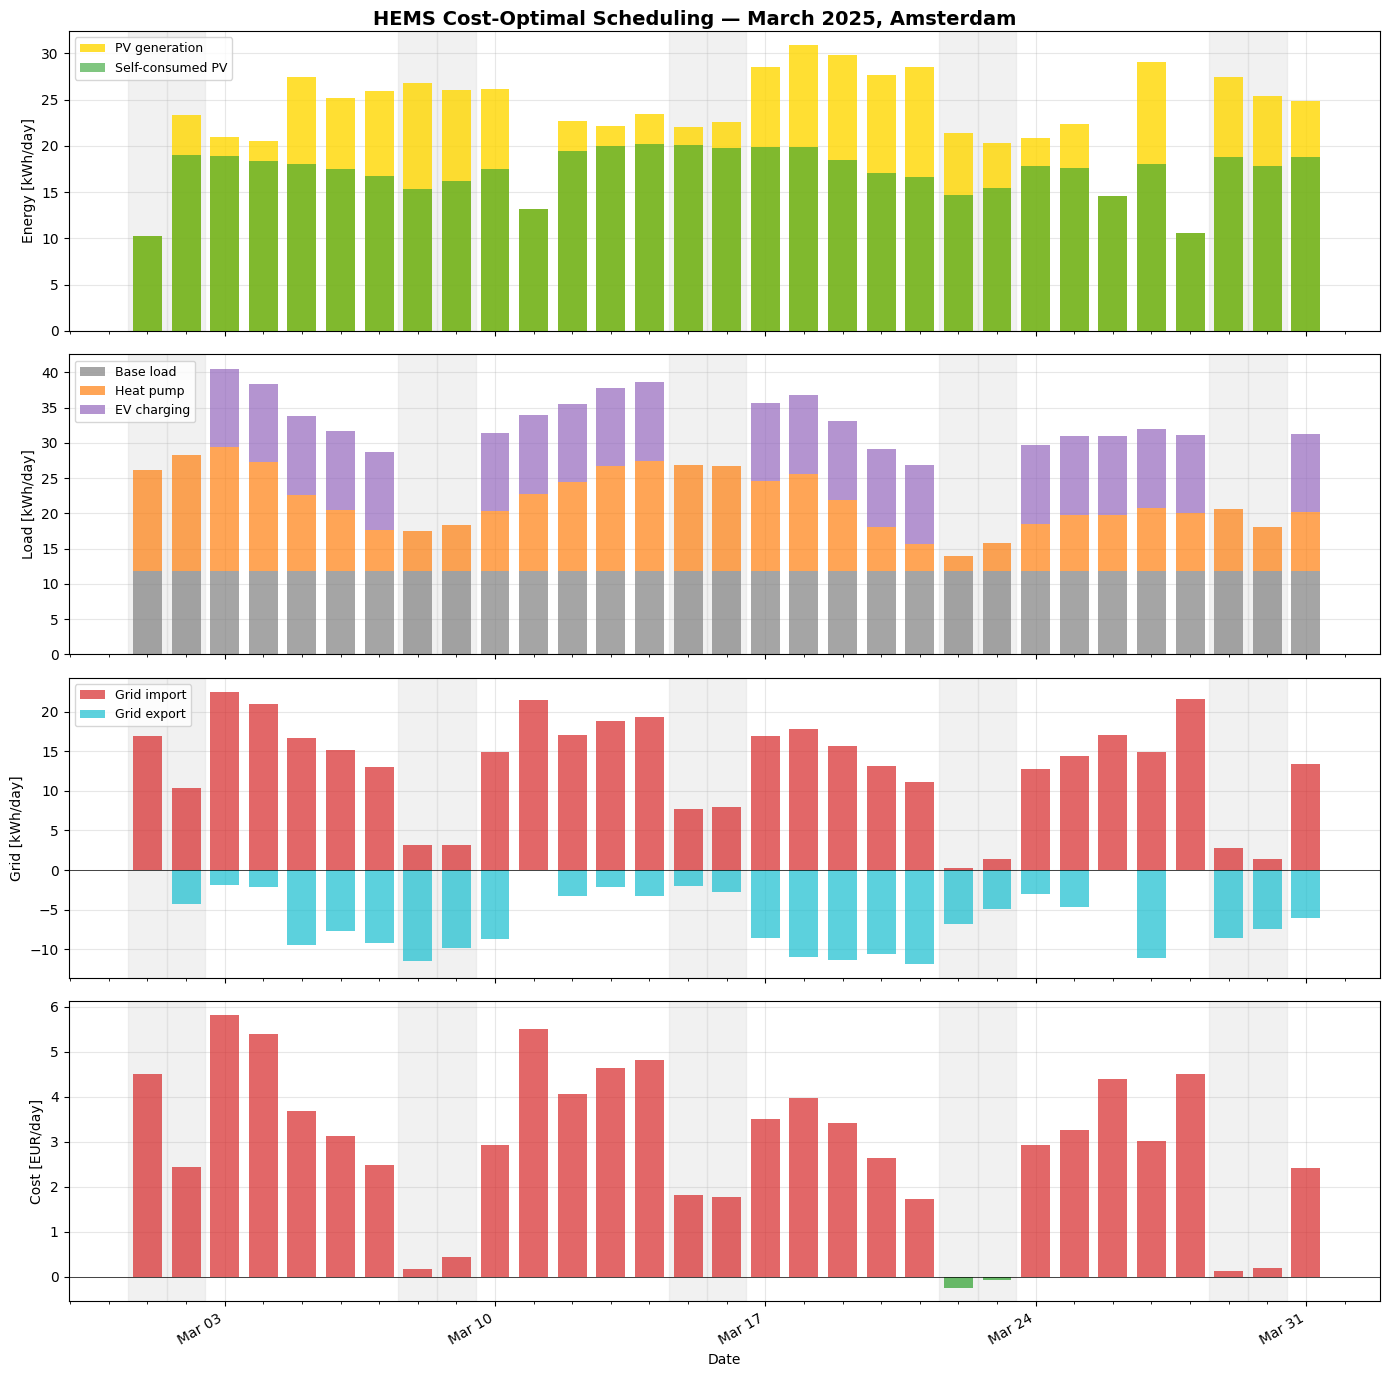

In [17]:
# --- Monthly overview: 4-panel daily bar chart ---
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

fig, axes = plt.subplots(4, 1, figsize=(14, 14), sharex=True)
fig.suptitle(
    "HEMS Cost-Optimal Scheduling — March 2025, Amsterdam",
    fontweight="bold", fontsize=14,
)

# Shade weekends
for ax in axes:
    for d in dates_march:
        if d.weekday() >= 5:
            ax.axvspan(
                d - pd.Timedelta(hours=12), d + pd.Timedelta(hours=12),
                color="lightgrey", alpha=0.3, zorder=0,
            )

bw = pd.Timedelta(hours=18)  # bar width

# Panel 1: PV generation & self-consumption
ax = axes[0]
ax.bar(daily.index, daily["pv_kWh"], width=bw, color="gold",
       alpha=0.8, label="PV generation", zorder=2)
ax.bar(daily.index, daily["sc_kWh"], width=bw, color="tab:green",
       alpha=0.6, label="Self-consumed PV", zorder=3)
ax.set_ylabel("Energy [kWh/day]")
ax.legend(loc="upper left", fontsize=9)
ax.grid(True, alpha=0.3, zorder=0)

# Panel 2: Load breakdown (stacked)
ax = axes[1]
b1 = daily["base_kWh"]
b2 = b1 + daily["hp_kWh"]
ax.bar(daily.index, daily["base_kWh"], width=bw, color="tab:grey",
       alpha=0.7, label="Base load", zorder=2)
ax.bar(daily.index, daily["hp_kWh"], bottom=b1, width=bw,
       color="tab:orange", alpha=0.7, label="Heat pump", zorder=2)
ax.bar(daily.index, daily["ev_kWh"], bottom=b2, width=bw,
       color="tab:purple", alpha=0.7, label="EV charging", zorder=2)
ax.set_ylabel("Load [kWh/day]")
ax.legend(loc="upper left", fontsize=9)
ax.grid(True, alpha=0.3, zorder=0)

# Panel 3: Grid interaction
ax = axes[2]
ax.bar(daily.index, daily["import_kWh"], width=bw, color="tab:red",
       alpha=0.7, label="Grid import", zorder=2)
ax.bar(daily.index, -daily["export_kWh"], width=bw, color="tab:cyan",
       alpha=0.7, label="Grid export", zorder=2)
ax.axhline(0, color="black", lw=0.5)
ax.set_ylabel("Grid [kWh/day]")
ax.legend(loc="upper left", fontsize=9)
ax.grid(True, alpha=0.3, zorder=0)

# Panel 4: Daily cost (net = import cost − export revenue)
ax = axes[3]
colors = ["tab:green" if c < 0 else "tab:red" for c in daily["cost_net"]]
ax.bar(daily.index, daily["cost_net"], width=bw, color=colors, alpha=0.7, zorder=2)
ax.axhline(0, color="black", lw=0.5)
ax.set_ylabel("Cost [EUR/day]")
ax.set_xlabel("Date")
ax.grid(True, alpha=0.3, zorder=0)

ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MO))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %d"))
ax.xaxis.set_minor_locator(mdates.DayLocator())
fig.autofmt_xdate(rotation=30)

plt.tight_layout()
plt.show()

/tmp/ipykernel_632358/2341303497.py:113: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


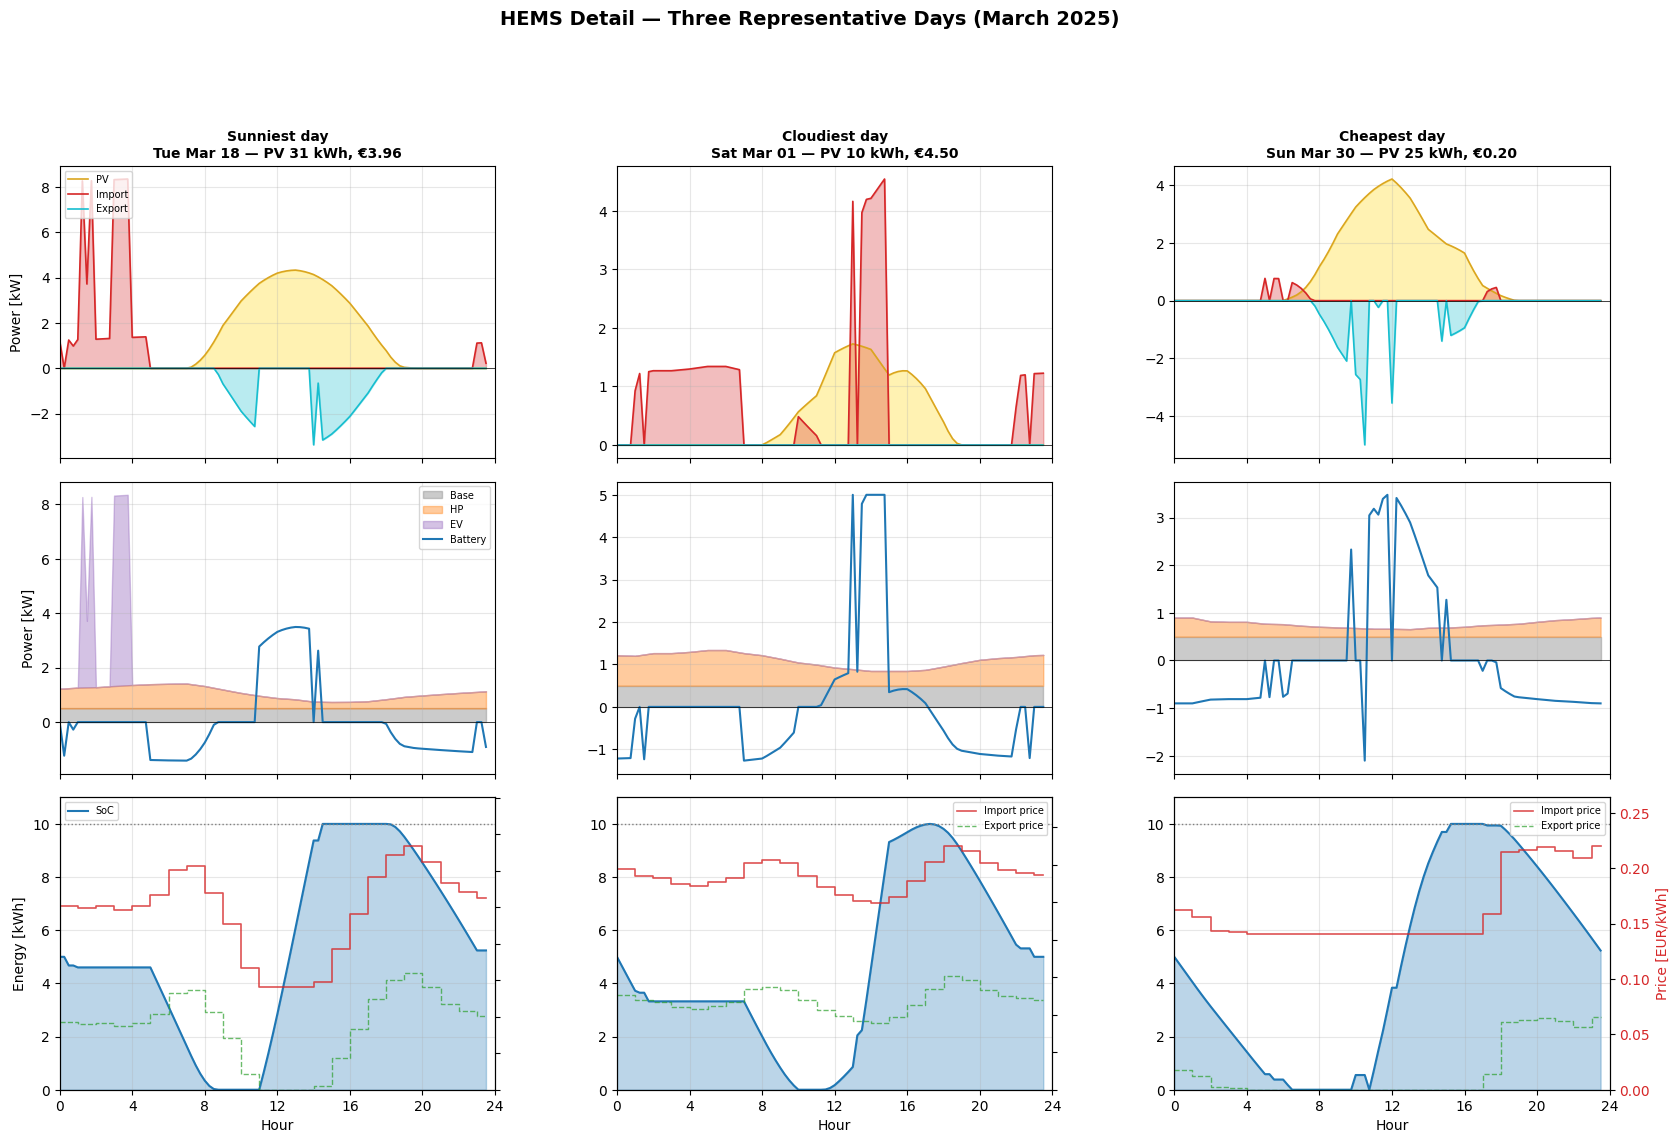

In [18]:
# --- Detailed view: 3 representative days ---
# Only consider days that were actually solved (non-zero cost or generation)
daily_solved = daily.loc[daily["import_kWh"] + daily["export_kWh"] > 0]

# Pick sunniest, cloudiest, and cheapest day — ensuring all three are distinct
day_sunny  = daily_solved["pv_kWh"].idxmax()
day_cloudy = daily_solved["pv_kWh"][daily_solved["pv_kWh"] > 0].idxmin()

# Cheapest day: exclude already-selected days so we get 3 unique days
used = {day_sunny, day_cloudy}
cheap_candidates = daily_solved["avg_price"].drop(index=used, errors="ignore").sort_values()
day_cheap = cheap_candidates.index[0]

selected_days = [
    (day_sunny,  "Sunniest day",  "gold"),
    (day_cloudy, "Cloudiest day", "tab:grey"),
    (day_cheap,  "Cheapest day",  "tab:green"),
]

def get_day_ts(ts_df, day_ts):
    """Get T consecutive steps for a day from the timeseries DataFrame."""
    midnight = pd.Timestamp(day_ts.strftime("%Y-%m-%d"), tz="Europe/Amsterdam")
    start = ts_df.index.searchsorted(midnight)
    return ts_df.iloc[start:start + T]

fig, all_axes = plt.subplots(
    3, 3, figsize=(20, 12),
    sharex=True,
    gridspec_kw={"hspace": 0.08, "wspace": 0.28},
)

for col, (day_ts, label, accent) in enumerate(selected_days):
    ts_day = get_day_ts(ts_march, day_ts)
    h_day = (ts_day.index - ts_day.index[0]).total_seconds() / 3600
    pv_kwh = daily.loc[day_ts, "pv_kWh"]
    cost = daily.loc[day_ts, "cost_net"]
    avg_p = daily.loc[day_ts, "avg_price"]

    # --- Row 0: Power flows ---
    ax = all_axes[0, col]
    ax.fill_between(h_day, ts_day["P_pv"], alpha=0.3, color="gold")
    ax.plot(h_day, ts_day["P_pv"], color="goldenrod", lw=1.2, label="PV")
    ax.fill_between(h_day, ts_day["P_import"], alpha=0.3, color="tab:red")
    ax.plot(h_day, ts_day["P_import"], color="tab:red", lw=1.2, label="Import")
    ax.fill_between(h_day, -ts_day["P_export"], alpha=0.3, color="tab:cyan")
    ax.plot(h_day, -ts_day["P_export"], color="tab:cyan", lw=1.2, label="Export")
    ax.axhline(0, color="black", lw=0.5)
    ax.set_title(
        f"{label}\n{day_ts.strftime('%a %b %d')} — "
        f"PV {pv_kwh:.0f} kWh, €{cost:.2f}",
        fontsize=10, fontweight="bold",
    )
    ax.grid(True, alpha=0.3)
    if col == 0:
        ax.set_ylabel("Power [kW]")
        ax.legend(loc="upper left", fontsize=7)

    # --- Row 1: Loads + battery ---
    ax = all_axes[1, col]
    ax.fill_between(h_day, ts_day["P_base"], alpha=0.4, color="tab:grey", label="Base")
    ax.fill_between(
        h_day, ts_day["P_base"] + ts_day["P_hp"],
        y2=ts_day["P_base"], alpha=0.4, color="tab:orange", label="HP",
    )
    ev_pos = np.maximum(ts_day["P_ev"].values, 0)
    bottom2 = ts_day["P_base"].values + ts_day["P_hp"].values
    ax.fill_between(h_day, bottom2 + ev_pos, y2=bottom2,
                    alpha=0.4, color="tab:purple", label="EV")
    ax.plot(h_day, ts_day["P_bat"], color="tab:blue", lw=1.5, label="Battery")
    ax.axhline(0, color="black", lw=0.5)
    ax.grid(True, alpha=0.3)
    if col == 0:
        ax.set_ylabel("Power [kW]")
        ax.legend(loc="upper right", fontsize=7)

    # --- Row 2: Battery SoC + price ---
    ax = all_axes[2, col]
    ax.fill_between(h_day, ts_day["E_bat"], alpha=0.3, color="tab:blue")
    ax.plot(h_day, ts_day["E_bat"], color="tab:blue", lw=1.5, label="SoC")
    ax.axhline(battery.E_max, color="grey", ls=":", lw=1)
    ax.set_ylim(0, battery.E_max * 1.1)
    ax.grid(True, alpha=0.3)
    ax.set_xlabel("Hour")
    ax.set_xlim(0, 24)
    ax.set_xticks(range(0, 25, 4))
    if col == 0:
        ax.set_ylabel("Energy [kWh]")
        ax.legend(loc="upper left", fontsize=7)

    # Price on twin axis — show effective consumer import price
    ax2 = ax.twinx()
    ax2.step(h_day, ts_day["price_import"].values, where="post", color="tab:red",
             ls="-", lw=1.2, alpha=0.8, label="Import price")
    ax2.step(h_day, ts_day["price_export"].values, where="post", color="tab:green",
             ls="--", lw=1.0, alpha=0.7, label="Export price")
    p_max = max(ts_day["price_import"].max() * 1.2, 0.15)
    ax2.set_ylim(0, p_max)
    ax2.tick_params(axis="y", labelcolor="tab:red")
    if col == 2:
        ax2.set_ylabel("Price [EUR/kWh]", color="tab:red")
        ax2.legend(loc="upper right", fontsize=7)
    elif col == 1:
        ax2.legend(loc="upper right", fontsize=7)
        ax2.set_yticklabels([])
    else:
        ax2.set_yticklabels([])

fig.suptitle(
    "HEMS Detail — Three Representative Days (March 2025)",
    fontweight="bold", fontsize=14, y=1.01,
)

plt.tight_layout()
plt.show()

/tmp/ipykernel_632358/3702339553.py:129: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


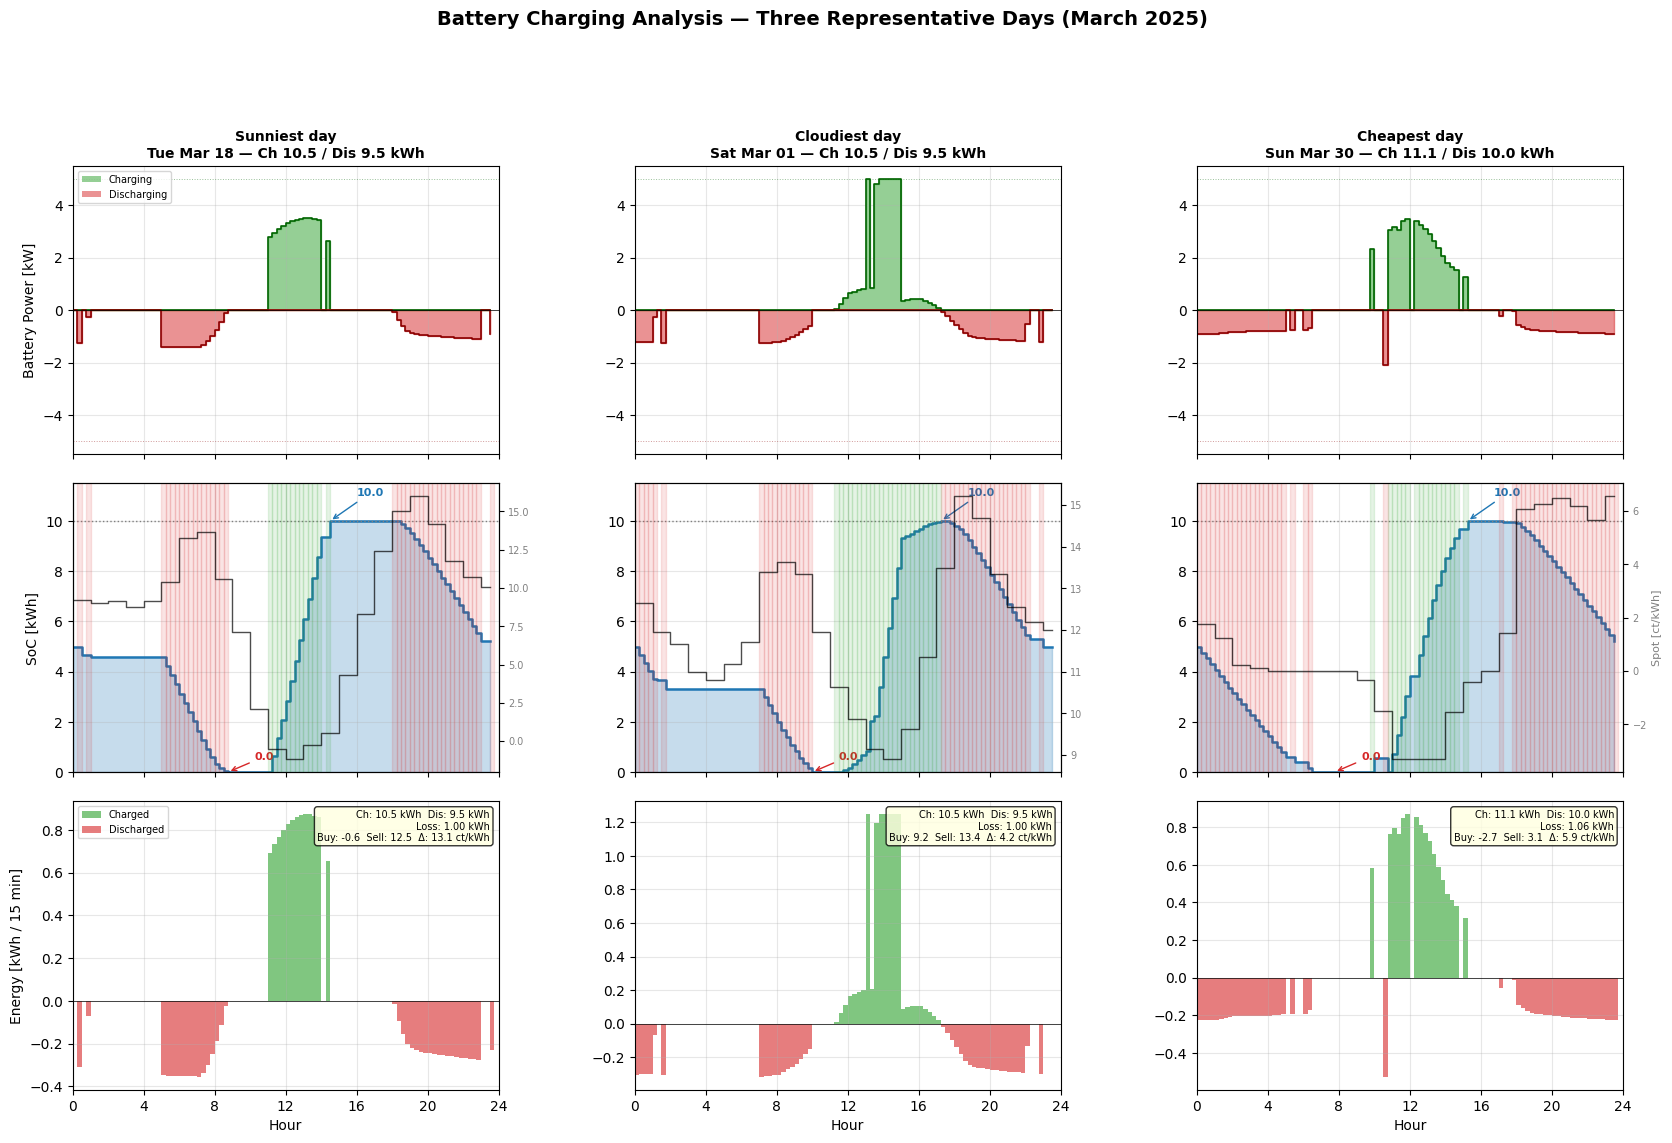

In [19]:

# ── Battery charging analysis — 3 representative March days ──────────────
from matplotlib.patches import Patch

fig, all_axes = plt.subplots(
    3, 3, figsize=(20, 12),
    sharex=True,
    gridspec_kw={"hspace": 0.10, "wspace": 0.32},
)

for col, (day_ts, label, accent) in enumerate(selected_days):
    ts_day = get_day_ts(ts_march, day_ts)
    h_day = (ts_day.index - ts_day.index[0]).total_seconds() / 3600

    # Derive charge / discharge from net battery power
    P_bat_net = ts_day["P_bat"].values
    P_ch_day  = np.maximum(P_bat_net, 0)      # positive = charging
    P_dis_day = np.maximum(-P_bat_net, 0)      # positive = discharging
    E_bat_day = ts_day["E_bat"].values
    spot_day  = ts_day["spot"].values

    # Energy throughput
    E_ch  = np.sum(P_ch_day) * DT_DEFAULT
    E_dis = np.sum(P_dis_day) * DT_DEFAULT
    E_loss = E_ch * (1 - battery.eta_ch) + E_dis * (1 - battery.eta_dis)

    # Price arbitrage
    mask_ch  = P_ch_day > 0.01
    mask_dis = P_dis_day > 0.01
    if mask_ch.any() and mask_dis.any():
        avg_buy  = np.average(spot_day[mask_ch], weights=P_ch_day[mask_ch])
        avg_sell = np.average(spot_day[mask_dis], weights=P_dis_day[mask_dis])
        spread   = avg_sell - avg_buy
    else:
        avg_buy = avg_sell = spread = 0.0

    # ── Row 0: Charge / discharge power ──────────────────────────────────
    ax = all_axes[0, col]
    ax.fill_between(h_day, P_ch_day, alpha=0.5, color="tab:green", step="post")
    ax.fill_between(h_day, -P_dis_day, alpha=0.5, color="tab:red", step="post")
    ax.step(h_day, P_ch_day, where="post", color="darkgreen", lw=1.2)
    ax.step(h_day, -P_dis_day, where="post", color="darkred", lw=1.2)
    ax.axhline(0, color="black", lw=0.5)
    ax.axhline(battery.P_ch_max, color="darkgreen", ls=":", lw=0.7, alpha=0.4)
    ax.axhline(-battery.P_dis_max, color="darkred", ls=":", lw=0.7, alpha=0.4)
    ax.set_title(
        f"{label}\n{day_ts.strftime('%a %b %d')} — "
        f"Ch {E_ch:.1f} / Dis {E_dis:.1f} kWh",
        fontsize=10, fontweight="bold",
    )
    ax.grid(True, alpha=0.3)
    if col == 0:
        ax.set_ylabel("Battery Power [kW]")
        ax.legend(
            handles=[Patch(fc="tab:green", alpha=0.5, label="Charging"),
                     Patch(fc="tab:red", alpha=0.5, label="Discharging")],
            loc="upper left", fontsize=7,
        )

    # ── Row 1: SoC + spot price with charge/discharge shading ────────────
    ax = all_axes[1, col]
    ax.fill_between(h_day, E_bat_day, alpha=0.25, color="tab:blue", step="post")
    ax.step(h_day, E_bat_day, where="post", color="tab:blue", lw=1.8)
    ax.axhline(battery.E_max, color="grey", ls=":", lw=1)
    ax.set_ylim(0, battery.E_max * 1.15)
    ax.grid(True, alpha=0.3)
    if col == 0:
        ax.set_ylabel("SoC [kWh]")

    # Annotate min / max
    i_mn, i_mx = np.argmin(E_bat_day), np.argmax(E_bat_day)
    if E_bat_day[i_mx] - E_bat_day[i_mn] > 0.5:  # only if there's meaningful cycling
        ax.annotate(f"{E_bat_day[i_mn]:.1f}",
                    xy=(h_day[i_mn], E_bat_day[i_mn]),
                    xytext=(h_day[i_mn]+1.5, max(E_bat_day[i_mn]-1.5, 0.5)),
                    arrowprops=dict(arrowstyle="->", color="tab:red", lw=1),
                    fontsize=8, color="tab:red", fontweight="bold")
        ax.annotate(f"{E_bat_day[i_mx]:.1f}",
                    xy=(h_day[i_mx], E_bat_day[i_mx]),
                    xytext=(h_day[i_mx]+1.5, min(E_bat_day[i_mx]+1, battery.E_max*1.1)),
                    arrowprops=dict(arrowstyle="->", color="tab:blue", lw=1),
                    fontsize=8, color="tab:blue", fontweight="bold")

    # Spot price on twin axis with charge/discharge shading
    ax2 = ax.twinx()
    ax2.step(h_day, spot_day * 100, where="post", color="black", lw=1.0, alpha=0.7)
    for t_i in range(len(h_day)):
        if P_ch_day[t_i] > 0.01:
            ax2.axvspan(h_day[t_i], h_day[t_i] + DT_DEFAULT,
                        alpha=0.12, color="tab:green")
        elif P_dis_day[t_i] > 0.01:
            ax2.axvspan(h_day[t_i], h_day[t_i] + DT_DEFAULT,
                        alpha=0.12, color="tab:red")
    ax2.tick_params(axis="y", labelcolor="grey", labelsize=7)
    if col == 2:
        ax2.set_ylabel("Spot [ct/kWh]", color="grey", fontsize=8)

    # ── Row 2: Arbitrage summary bar / text ──────────────────────────────
    ax = all_axes[2, col]
    # Show hourly energy flow as stacked positive/negative bars
    ax.bar(h_day, P_ch_day * DT_DEFAULT, width=DT_DEFAULT, align="edge",
           color="tab:green", alpha=0.6, label="Charged")
    ax.bar(h_day, -P_dis_day * DT_DEFAULT, width=DT_DEFAULT, align="edge",
           color="tab:red", alpha=0.6, label="Discharged")
    ax.axhline(0, color="black", lw=0.5)
    ax.set_xlabel("Hour")
    ax.set_xlim(0, 24)
    ax.set_xticks(range(0, 25, 4))
    ax.grid(True, alpha=0.3)
    if col == 0:
        ax.set_ylabel("Energy [kWh / 15 min]")
        ax.legend(loc="upper left", fontsize=7)

    # Text box with stats
    stats = (
        f"Ch: {E_ch:.1f} kWh  Dis: {E_dis:.1f} kWh\n"
        f"Loss: {E_loss:.2f} kWh\n"
        f"Buy: {avg_buy*100:.1f}  Sell: {avg_sell*100:.1f}  "
        f"Δ: {spread*100:.1f} ct/kWh"
    )
    ax.text(0.98, 0.97, stats, transform=ax.transAxes,
            fontsize=7, va="top", ha="right",
            bbox=dict(boxstyle="round,pad=0.3", fc="lightyellow", alpha=0.8))

fig.suptitle(
    "Battery Charging Analysis — Three Representative Days (March 2025)",
    fontweight="bold", fontsize=14, y=1.01,
)

plt.tight_layout()
plt.show()


In [24]:

# ── Diagnostic: is the battery cycling at all during March? ──────────────
print("Battery activity check — ts_march['P_bat']:")
print(f"  min: {ts_march['P_bat'].min():.4f} kW")
print(f"  max: {ts_march['P_bat'].max():.4f} kW")
print(f"  abs mean: {ts_march['P_bat'].abs().mean():.6f} kW")
print(f"  non-zero steps: {(ts_march['P_bat'].abs() > 0.01).sum()} / {len(ts_march)}")
print()

# Check SoC range per day
print("Daily SoC range (E_bat):")
for day_ts in dates_march:
    ds_day = get_day_ts(ts_march, day_ts)
    if len(ds_day) == 0:
        continue
    e_min, e_max = ds_day["E_bat"].min(), ds_day["E_bat"].max()
    p_bat_max = ds_day["P_bat"].abs().max()
    flag = " ◄ cycling" if e_max - e_min > 0.5 else ""
    print(f"  {day_ts.strftime('%b %d')}: SoC {e_min:.2f}–{e_max:.2f} kWh  "
          f"|P_bat|_max={p_bat_max:.2f} kW{flag}")


Battery activity check — ts_march['P_bat']:
  min: -5.0000 kW
  max: 5.0000 kW
  abs mean: 0.831651 kW
  non-zero steps: 1875 / 2945

Daily SoC range (E_bat):
  Mar 01: SoC 0.00–10.00 kWh  |P_bat|_max=5.00 kW ◄ cycling
  Mar 02: SoC 0.00–10.00 kWh  |P_bat|_max=3.03 kW ◄ cycling
  Mar 03: SoC 0.00–10.00 kWh  |P_bat|_max=2.83 kW ◄ cycling
  Mar 04: SoC 0.00–10.00 kWh  |P_bat|_max=3.00 kW ◄ cycling
  Mar 05: SoC 0.00–10.00 kWh  |P_bat|_max=3.38 kW ◄ cycling
  Mar 06: SoC 0.00–10.00 kWh  |P_bat|_max=3.64 kW ◄ cycling
  Mar 07: SoC 0.00–10.00 kWh  |P_bat|_max=4.61 kW ◄ cycling
  Mar 08: SoC 0.00–10.00 kWh  |P_bat|_max=5.00 kW ◄ cycling
  Mar 09: SoC 0.00–10.00 kWh  |P_bat|_max=3.52 kW ◄ cycling
  Mar 10: SoC 0.00–10.00 kWh  |P_bat|_max=3.38 kW ◄ cycling
  Mar 11: SoC 4.91–10.00 kWh  |P_bat|_max=5.00 kW ◄ cycling
  Mar 12: SoC 0.00–10.00 kWh  |P_bat|_max=2.65 kW ◄ cycling
  Mar 13: SoC 0.00–10.00 kWh  |P_bat|_max=2.31 kW ◄ cycling
  Mar 14: SoC 0.00–10.00 kWh  |P_bat|_max=2.43 kW ◄ cycling
 

In [25]:

# ── Diagnostic: re-solve sunniest March day and inspect battery ──────────
# Use day_sunny from the representative days selection
ds_test = day_sunny.strftime("%Y-%m-%d")
midnight_test = pd.Timestamp(ds_test, tz="Europe/Amsterdam")

w_start_t = weather_mar.index.searchsorted(midnight_test)
w_test = weather_mar.iloc[w_start_t:w_start_t + T]

p_start_t = prices_mar.index.searchsorted(midnight_test)
day_prices_t = np.maximum(prices_mar.iloc[p_start_t:p_start_t + T].values, 0.0)

# Reset battery to 50% SoC
battery.E_0.value = battery.E_max / 2
battery.E_T.value = battery.E_0.value

# Update HEMS
hems.price.value = day_prices_t
pv.compute_generation(
    times=w_test.index, ghi=w_test["ghi"].values, temp_air=w_test["temp_air"].values,
    wind_speed=w_test["wind_speed"].values, dni=w_test["dni"].values, dhi=w_test["dhi"].values,
)
_hp_t = HeatPump(T_amb=w_test["temp_air"].values, dt=DT_DEFAULT, T_supply=35.0)
hp.P.value = _hp_t.P.value

# Weekday
ev.schedule_trips([(8*4, 18*4, 10.0)])
ev.E_0.value = 20.0
ev.E_T.value = ev.E_0.value

res_test = hems.solve()

print(f"Day: {ds_test} ({day_sunny.strftime('%A')})")
print(f"Status: {res_test['status']}, Cost: €{res_test['cost']:.2f}")
print(f"PV: {np.sum(hems.total_pv_generation)*DT_DEFAULT:.1f} kWh")
print(f"Import: {np.sum(res_test['P_import'])*DT_DEFAULT:.1f} kWh")
print(f"Export: {np.sum(res_test['P_export'])*DT_DEFAULT:.1f} kWh")
print()
print("Battery variables after solve:")
print(f"  P.value     min/max: {battery.P.value.min():.4f} / {battery.P.value.max():.4f} kW")
print(f"  P_ch.value  min/max: {battery.P_ch.value.min():.4f} / {battery.P_ch.value.max():.4f} kW")
print(f"  P_dis.value min/max: {battery.P_dis.value.min():.4f} / {battery.P_dis.value.max():.4f} kW")
print(f"  E.value     min/max: {battery.E.value.min():.2f} / {battery.E.value.max():.2f} kWh")
print(f"  z.value     unique : {np.unique(np.round(battery.z.value, 1))}")
print(f"  E_0={battery.E_0.value:.2f}, E_T={battery.E_T.value:.2f}")
print()

# Check if battery constraints are in the problem
bat_constrs = [c for c in hems.problem.constraints
               if any(battery.name in str(v) for v in c.variables())]
print(f"Battery constraints in problem: {len(bat_constrs)}")
for c in bat_constrs[:5]:
    vars_str = ", ".join(v.name() for v in c.variables())
    print(f"  {c} → vars: {vars_str}")


Day: 2025-03-18 (Tuesday)
Status: optimal, Cost: €3.96
PV: 30.9 kWh
Import: 17.9 kWh
Export: 11.0 kWh

Battery variables after solve:
  P.value     min/max: -1.4164 / 3.4960 kW
  P_ch.value  min/max: 0.0000 / 3.4960 kW
  P_dis.value min/max: 0.0000 / 1.4164 kW
  E.value     min/max: 0.00 / 10.00 kWh
  z.value     unique : [0. 1.]
  E_0=5.00, E_T=5.00

Battery constraints in problem: 9
  P_import_kW + -P_export_kW == param285 + param307 + EV_P_kW + Battery_P_kW + -Solar_P_kW → vars: P_import_kW, P_export_kW, EV_P_kW, Battery_P_kW, Solar_P_kW
  Battery_SoC_kWh[0] == Battery_E0_kWh → vars: Battery_SoC_kWh
  Battery_SoC_kWh[1:96] == Battery_SoC_kWh[0:95] + Promote(0.25, (95,)) * (Promote(0.95, (95,)) * Battery_P_ch_kW + -(Promote(1.0526315789473684, (95,)) * Battery_P_dis_kW)) + -Battery_drain_kWh → vars: Battery_SoC_kWh, Battery_P_ch_kW, Battery_P_dis_kW
  0.0 <= Battery_SoC_kWh → vars: Battery_SoC_kWh
  Battery_SoC_kWh <= 10.0 → vars: Battery_SoC_kWh


## December 1st

Weather: 189 records  (2025-12-01 00:00:00+01:00 → 2025-12-02 23:00:00+01:00)
Price  : 95 steps, mean 8.32 ct/kWh

Status: optimal
Cost  : EUR 7.34
Import: 33.4 kWh
Export: 0.0 kWh
PV gen: 1.8 kWh
HP    : 11.2 kWh


/tmp/ipykernel_632358/1232985068.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


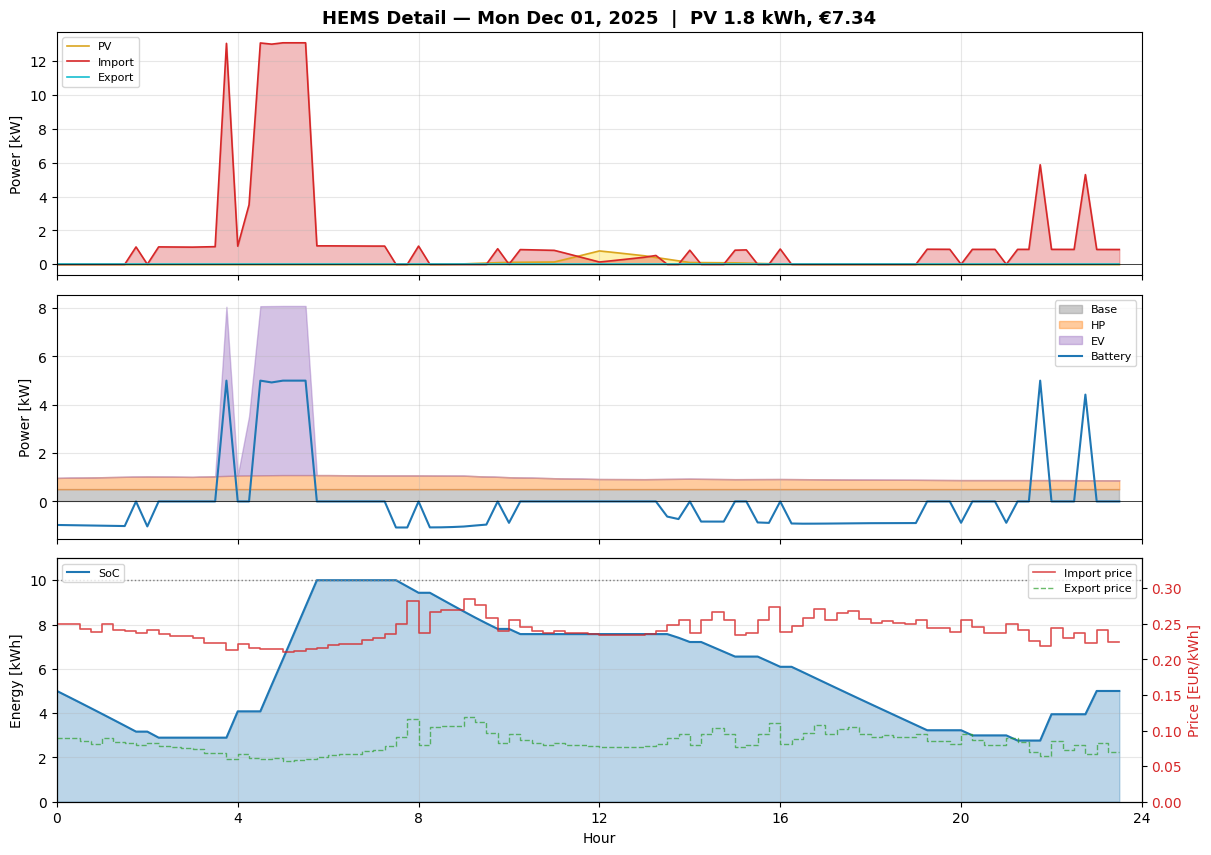

In [26]:

# ── Fetch December weather ──────────────────────────────────────────────
weather_dec = fetch_open_meteo(
    latitude=52.37, longitude=4.90,
    start_date="2025-12-01", end_date="2025-12-02",
    timezone="Europe/Amsterdam",
)
weather_dec = resample_weather(weather_dec, dt=DT_DEFAULT)
print(f"Weather: {len(weather_dec)} records  ({weather_dec.index[0]} → {weather_dec.index[-1]})")

# ── Extract December 1st prices ────────────────────────────────────────
prices_dec1 = prices_nl.loc["2025-12-01", "price_eur_kwh"]
day_prices_dec = prices_dec1.values[:T]
price_day_dec = np.maximum(day_prices_dec, 0.0)
print(f"Price  : {len(day_prices_dec)} steps, mean {np.mean(day_prices_dec)*100:.2f} ct/kWh")

# ── Set up components for Dec 1 (Monday) ──────────────────────────────
w_dec = weather_dec.iloc[:T]

# Update HEMS parameters
hems.price.value = price_day_dec

pv.compute_generation(
    times=w_dec.index, ghi=w_dec["ghi"].values, temp_air=w_dec["temp_air"].values,
    wind_speed=w_dec["wind_speed"].values, dni=w_dec["dni"].values, dhi=w_dec["dhi"].values,
)

_hp_dec = HeatPump(T_amb=w_dec["temp_air"].values, dt=DT_DEFAULT, T_supply=35.0)
hp.P.value = _hp_dec.P.value

# Dec 1, 2025 is a Monday → weekday commute
ev.schedule_trips([(8 * 4, 18 * 4, 10.0)])
battery.E_0.value = battery.E_max / 2
ev.E_0.value = 20.0
ev.E_T.value = ev.E_0.value
battery.E_T.value = battery.E_0.value

# ── Solve ─────────────────────────────────────────────────────────────
res_dec = hems.solve()
print(f"\nStatus: {res_dec['status']}")
print(f"Cost  : EUR {res_dec['cost']:.2f}")
print(f"Import: {np.sum(res_dec['P_import']) * DT_DEFAULT:.1f} kWh")
print(f"Export: {np.sum(res_dec['P_export']) * DT_DEFAULT:.1f} kWh")
print(f"PV gen: {np.sum(hems.total_pv_generation) * DT_DEFAULT:.1f} kWh")
print(f"HP    : {np.sum(hp.P.value) * DT_DEFAULT:.1f} kWh")

# ── Effective consumer prices ─────────────────────────────────────────
vf_dec = 1.0 + VAT
p_import_dec = (price_day_dec + PROCUREMENT_FEE + ENERGY_TAX) * vf_dec
p_export_dec = price_day_dec + SELL_BACK_CREDIT

# ── Build single-day DataFrame ────────────────────────────────────────
ts_dec1 = pd.DataFrame({
    "P_import":  res_dec["P_import"],
    "P_export":  res_dec["P_export"],
    "P_pv":      hems.total_pv_generation,
    "P_bat":     battery.P.value,
    "P_hp":      hp.P.value,
    "P_ev":      ev.P.value,
    "P_base":    base_load.P.value * np.ones(T),
    "E_bat":     battery.E.value[:-1],
    "spot":      day_prices_dec,
    "price_import": p_import_dec,
    "price_export": p_export_dec,
}, index=w_dec.index)

hours_dec = (ts_dec1.index - ts_dec1.index[0]).total_seconds() / 3600

# ── 3-row plot ────────────────────────────────────────────────────────
fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True,
                          gridspec_kw={"hspace": 0.08})

cost_dec = res_dec["cost"]
pv_kwh_dec = np.sum(hems.total_pv_generation) * DT_DEFAULT

# Row 0 — Power flows
ax = axes[0]
ax.fill_between(hours_dec, ts_dec1["P_pv"], alpha=0.3, color="gold")
ax.plot(hours_dec, ts_dec1["P_pv"], color="goldenrod", lw=1.2, label="PV")
ax.fill_between(hours_dec, ts_dec1["P_import"], alpha=0.3, color="tab:red")
ax.plot(hours_dec, ts_dec1["P_import"], color="tab:red", lw=1.2, label="Import")
ax.fill_between(hours_dec, -ts_dec1["P_export"], alpha=0.3, color="tab:cyan")
ax.plot(hours_dec, -ts_dec1["P_export"], color="tab:cyan", lw=1.2, label="Export")
ax.axhline(0, color="black", lw=0.5)
ax.set_ylabel("Power [kW]")
ax.legend(loc="upper left", fontsize=8)
ax.grid(True, alpha=0.3)
ax.set_title(
    f"HEMS Detail — Mon Dec 01, 2025  |  PV {pv_kwh_dec:.1f} kWh, €{cost_dec:.2f}",
    fontsize=13, fontweight="bold",
)

# Row 1 — Load breakdown + battery power
ax = axes[1]
ax.fill_between(hours_dec, ts_dec1["P_base"], alpha=0.4, color="tab:grey", label="Base")
ax.fill_between(hours_dec, ts_dec1["P_base"] + ts_dec1["P_hp"],
                y2=ts_dec1["P_base"], alpha=0.4, color="tab:orange", label="HP")
ev_pos_dec = np.maximum(ts_dec1["P_ev"].values, 0)
bot = ts_dec1["P_base"].values + ts_dec1["P_hp"].values
ax.fill_between(hours_dec, bot + ev_pos_dec, y2=bot,
                alpha=0.4, color="tab:purple", label="EV")
ax.plot(hours_dec, ts_dec1["P_bat"], color="tab:blue", lw=1.5, label="Battery")
ax.axhline(0, color="black", lw=0.5)
ax.set_ylabel("Power [kW]")
ax.legend(loc="upper right", fontsize=8)
ax.grid(True, alpha=0.3)

# Row 2 — Battery SoC + price
ax = axes[2]
ax.fill_between(hours_dec, ts_dec1["E_bat"], alpha=0.3, color="tab:blue")
ax.plot(hours_dec, ts_dec1["E_bat"], color="tab:blue", lw=1.5, label="SoC")
ax.axhline(battery.E_max, color="grey", ls=":", lw=1)
ax.set_ylim(0, battery.E_max * 1.1)
ax.set_ylabel("Energy [kWh]")
ax.legend(loc="upper left", fontsize=8)
ax.grid(True, alpha=0.3)
ax.set_xlabel("Hour")
ax.set_xlim(0, 24)
ax.set_xticks(range(0, 25, 4))

# Price on twin axis
ax2 = ax.twinx()
ax2.step(hours_dec, ts_dec1["price_import"].values, where="post",
         color="tab:red", ls="-", lw=1.2, alpha=0.8, label="Import price")
ax2.step(hours_dec, ts_dec1["price_export"].values, where="post",
         color="tab:green", ls="--", lw=1.0, alpha=0.7, label="Export price")
p_max_dec = max(ts_dec1["price_import"].max() * 1.2, 0.15)
ax2.set_ylim(0, p_max_dec)
ax2.set_ylabel("Price [EUR/kWh]", color="tab:red")
ax2.tick_params(axis="y", labelcolor="tab:red")
ax2.legend(loc="upper right", fontsize=8)

plt.tight_layout()
plt.show()


Battery Analysis — Dec 01, 2025
  Capacity       : 10.0 kWh  (5.0/5.0 kW ch/dis)
  Efficiency     : η_ch=95%, η_dis=95%
  SoC start→end  : 5.00 → 5.00 kWh
  SoC min / max  : 2.76 / 10.00 kWh

  Energy charged  : 9.84 kWh
  Energy discharged: 8.88 kWh
  Losses          : 0.936 kWh
  Utilisation     : 98% of capacity

  Avg buy  spot   :   6.12 ct/kWh
  Avg sell spot   :   9.63 ct/kWh
  Spread          :   3.50 ct/kWh
  Arbitrage saving: €0.295


/tmp/ipykernel_632358/1846913952.py:129: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


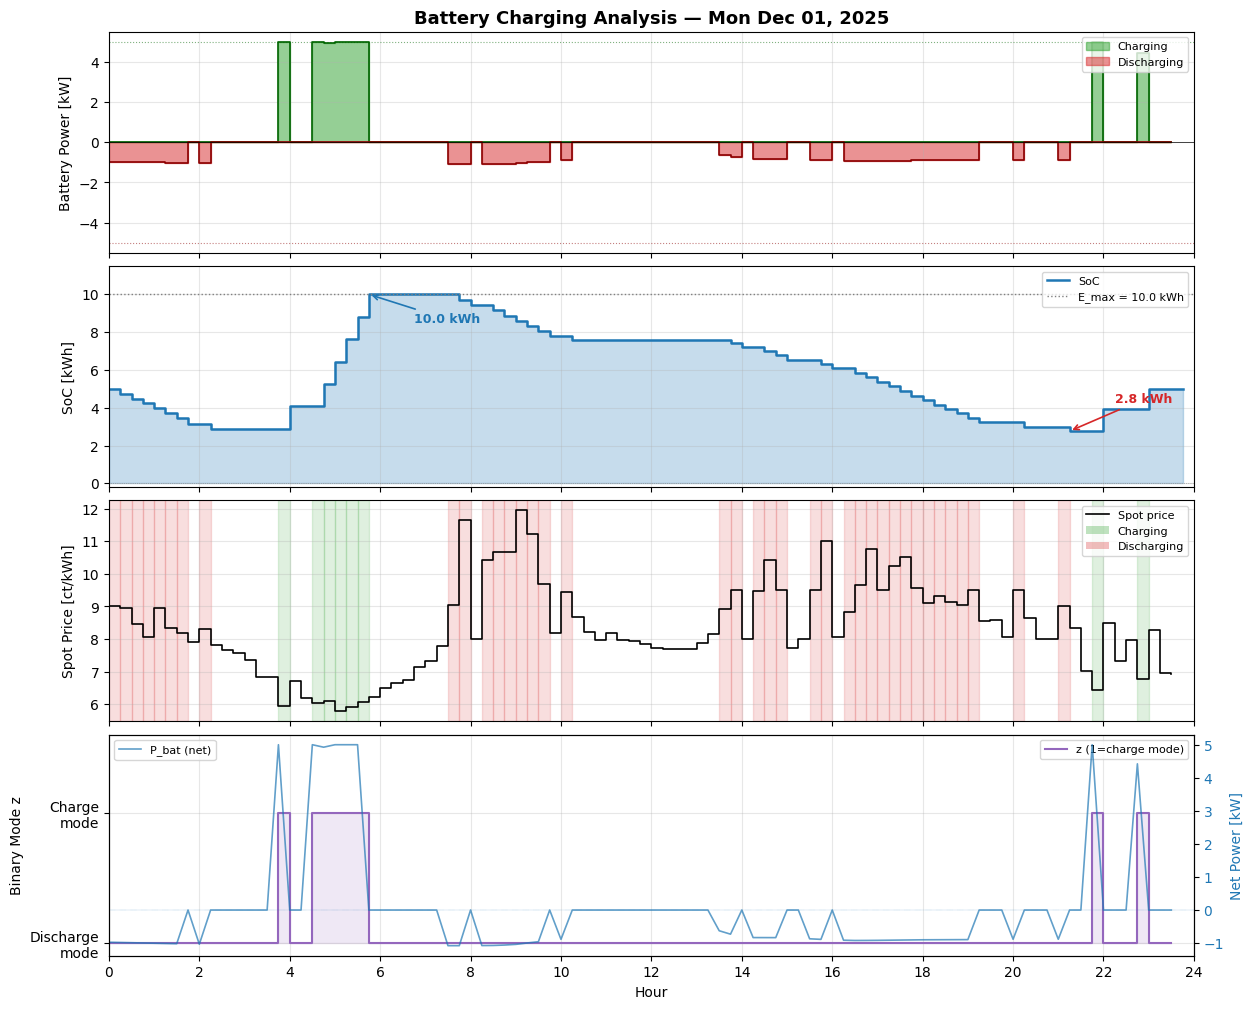

In [27]:

# ── Battery charging analysis — Dec 1, 2025 ─────────────────────────────
P_ch_dec  = battery.P_ch.value          # charging power  [kW]  (≥0)
P_dis_dec = battery.P_dis.value         # discharging power [kW] (≥0)
E_bat_dec = battery.E.value             # SoC [kWh], length T+1
z_dec     = battery.z.value             # mode: 1=charging, 0=discharging

# Energy throughput
E_charged    = np.sum(P_ch_dec) * DT_DEFAULT
E_discharged = np.sum(P_dis_dec) * DT_DEFAULT
E_losses     = E_charged * (1 - battery.eta_ch) + E_discharged * (1 - battery.eta_dis)
roundtrip    = (E_discharged * battery.eta_dis) / max(E_charged * battery.eta_ch, 1e-9) * 100

# Price arbitrage analysis
spot_ch  = day_prices_dec[P_ch_dec > 0.01]
spot_dis = day_prices_dec[P_dis_dec > 0.01]

print("Battery Analysis — Dec 01, 2025")
print("=" * 50)
print(f"  Capacity       : {battery.E_max:.1f} kWh  ({battery.P_ch_max:.1f}/{battery.P_dis_max:.1f} kW ch/dis)")
print(f"  Efficiency     : η_ch={battery.eta_ch:.0%}, η_dis={battery.eta_dis:.0%}")
print(f"  SoC start→end  : {E_bat_dec[0]:.2f} → {E_bat_dec[-1]:.2f} kWh")
print(f"  SoC min / max  : {E_bat_dec.min():.2f} / {E_bat_dec.max():.2f} kWh")
print()
print(f"  Energy charged  : {E_charged:.2f} kWh")
print(f"  Energy discharged: {E_discharged:.2f} kWh")
print(f"  Losses          : {E_losses:.3f} kWh")
print(f"  Utilisation     : {E_charged / battery.E_max * 100:.0f}% of capacity")
print()
if len(spot_ch) > 0 and len(spot_dis) > 0:
    avg_buy  = np.average(spot_ch, weights=P_ch_dec[P_ch_dec > 0.01])
    avg_sell = np.average(spot_dis, weights=P_dis_dec[P_dis_dec > 0.01])
    spread   = avg_sell - avg_buy
    savings  = spread * E_discharged * battery.eta_dis
    print(f"  Avg buy  spot   : {avg_buy*100:6.2f} ct/kWh")
    print(f"  Avg sell spot   : {avg_sell*100:6.2f} ct/kWh")
    print(f"  Spread          : {spread*100:6.2f} ct/kWh")
    print(f"  Arbitrage saving: €{savings:.3f}")
else:
    print("  No meaningful charge/discharge cycles detected.")

# ── 4-panel battery-focused plot ─────────────────────────────────────────
fig, axes = plt.subplots(4, 1, figsize=(14, 12), sharex=True,
                          gridspec_kw={"hspace": 0.06})

h = hours_dec  # reuse from Dec 1 cell

# Panel 0 — Charge / discharge power
ax = axes[0]
ax.fill_between(h, P_ch_dec, alpha=0.5, color="tab:green", label="Charging", step="post")
ax.fill_between(h, -P_dis_dec, alpha=0.5, color="tab:red", label="Discharging", step="post")
ax.step(h, P_ch_dec, where="post", color="darkgreen", lw=1.2)
ax.step(h, -P_dis_dec, where="post", color="darkred", lw=1.2)
ax.axhline(0, color="black", lw=0.5)
ax.axhline(battery.P_ch_max, color="darkgreen", ls=":", lw=0.8, alpha=0.5)
ax.axhline(-battery.P_dis_max, color="darkred", ls=":", lw=0.8, alpha=0.5)
ax.set_ylabel("Battery Power [kW]")
ax.legend(loc="upper right", fontsize=8)
ax.grid(True, alpha=0.3)
ax.set_title("Battery Charging Analysis — Mon Dec 01, 2025",
             fontsize=13, fontweight="bold")

# Panel 1 — State of charge
ax = axes[1]
h_soc = np.append(h, h[-1] + DT_DEFAULT)  # T+1 points for SoC
ax.fill_between(h_soc, E_bat_dec, alpha=0.25, color="tab:blue", step="post")
ax.step(h_soc, E_bat_dec, where="post", color="tab:blue", lw=1.8, label="SoC")
ax.axhline(battery.E_max, color="grey", ls=":", lw=1, label=f"E_max = {battery.E_max} kWh")
ax.axhline(0, color="grey", ls=":", lw=0.5)
ax.set_ylim(-0.2, battery.E_max * 1.15)
ax.set_ylabel("SoC [kWh]")
ax.legend(loc="upper right", fontsize=8)
ax.grid(True, alpha=0.3)

# Annotate min/max SoC
i_min, i_max = np.argmin(E_bat_dec), np.argmax(E_bat_dec)
ax.annotate(f"{E_bat_dec[i_min]:.1f} kWh",
            xy=(h_soc[i_min], E_bat_dec[i_min]),
            xytext=(h_soc[i_min]+1, E_bat_dec[i_min]+1.5),
            arrowprops=dict(arrowstyle="->", color="tab:red", lw=1.2),
            fontsize=9, color="tab:red", fontweight="bold")
ax.annotate(f"{E_bat_dec[i_max]:.1f} kWh",
            xy=(h_soc[i_max], E_bat_dec[i_max]),
            xytext=(h_soc[i_max]+1, E_bat_dec[i_max]-1.5),
            arrowprops=dict(arrowstyle="->", color="tab:blue", lw=1.2),
            fontsize=9, color="tab:blue", fontweight="bold")

# Panel 2 — Spot price with charge/discharge shading
ax = axes[2]
ax.step(h, day_prices_dec * 100, where="post", color="black", lw=1.2, label="Spot price")
# Shade charging periods green, discharging red
for t_i in range(T):
    if P_ch_dec[t_i] > 0.01:
        ax.axvspan(h[t_i], h[t_i] + DT_DEFAULT, alpha=0.15, color="tab:green")
    elif P_dis_dec[t_i] > 0.01:
        ax.axvspan(h[t_i], h[t_i] + DT_DEFAULT, alpha=0.15, color="tab:red")
ax.set_ylabel("Spot Price [ct/kWh]")
ax.legend(loc="upper right", fontsize=8)
ax.grid(True, alpha=0.3)
# Add charge/discharge legend patches
from matplotlib.patches import Patch
ax.legend(handles=[
    ax.get_lines()[0],
    Patch(facecolor="tab:green", alpha=0.3, label="Charging"),
    Patch(facecolor="tab:red", alpha=0.3, label="Discharging"),
], loc="upper right", fontsize=8)

# Panel 3 — Mode variable z + net battery power
ax = axes[3]
ax.step(h, z_dec, where="post", color="tab:purple", lw=1.5, label="z (1=charge mode)")
ax.fill_between(h, z_dec, alpha=0.15, color="tab:purple", step="post")
ax.set_ylim(-0.1, 1.6)
ax.set_yticks([0, 1])
ax.set_yticklabels(["Discharge\nmode", "Charge\nmode"])
ax.set_ylabel("Binary Mode z")
ax.grid(True, alpha=0.3)
ax.set_xlabel("Hour")
ax.set_xlim(0, 24)
ax.set_xticks(range(0, 25, 2))

# Overlay net power on twin axis
ax2 = ax.twinx()
ax2.plot(h, ts_dec1["P_bat"].values, color="tab:blue", lw=1.2, alpha=0.7, label="P_bat (net)")
ax2.set_ylabel("Net Power [kW]", color="tab:blue")
ax2.tick_params(axis="y", labelcolor="tab:blue")
ax2.axhline(0, color="tab:blue", lw=0.3, ls=":")
ax2.legend(loc="upper left", fontsize=8)
ax.legend(loc="upper right", fontsize=8)

plt.tight_layout()
plt.show()
